# PyTorch RL Tutorial

## Intro to TorchRL

In [2]:
!pip install tensordict-nightly
!pip install torchrl-nightly

/home/sunzid/anaconda3/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=9298) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


INFO: pip is looking at multiple versions of tensordict-nightly to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of tensordict-nightly to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.4 MB/s eta 0:00:00a 0:00:01
INFO: pip is looking at multiple versions of torchrl-nightly to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of torchrl-nightly to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You mig

In [8]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 7.2 MB/s eta 0:00:00a 0:00:01


### Data

In [11]:
import torch
from tensordict import TensorDict

#### TensorDict

In [14]:
batch_size = 5

torch.zeros(batch_size, 3)

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [15]:
batch_size = 5
tensordict = TensorDict(
    source={
        "key 1": torch.zeros(batch_size, 3),
        "key 2": torch.zeros(batch_size, 5, 6, dtype=torch.bool),
    },
    batch_size=[batch_size]
)

print(tensordict)

TensorDict(
    fields={
        key 1: Tensor(shape=torch.Size([5, 3]), device=cpu, dtype=torch.float32, is_shared=False),
        key 2: Tensor(shape=torch.Size([5, 5, 6]), device=cpu, dtype=torch.bool, is_shared=False)},
    batch_size=torch.Size([5]),
    device=None,
    is_shared=False)


Indexing TensorDict

In [20]:
print(tensordict[2],'\n')
print(tensordict["key 1"] is tensordict.get("key 1"))

TensorDict(
    fields={
        key 1: Tensor(shape=torch.Size([3]), device=cpu, dtype=torch.float32, is_shared=False),
        key 2: Tensor(shape=torch.Size([5, 6]), device=cpu, dtype=torch.bool, is_shared=False)},
    batch_size=torch.Size([]),
    device=None,
    is_shared=False) 

True


Stacking multiple TensorDicts

In [ ]:
tensordict1 = TensorDict(
    source={
        "key 1": torch.
    }
)

### Environments, TED and transform
The standard RL training loop: train a model/policy to accomplish a task in an environment (e.g., a simulator).

:mod:`~torchrl.envs` environment wrapper.

In [9]:
from torchrl.envs import GymEnv

env = GymEnv("Pendulum-v1")

In [10]:
reset = env.reset()
print(reset)

TensorDict(
    fields={
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        observation: Tensor(shape=torch.Size([3]), device=cpu, dtype=torch.float32, is_shared=False),
        terminated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        truncated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False)},
    batch_size=torch.Size([]),
    device=None,
    is_shared=False)


### TorchRL's modules

### Losses and optimization

### Data collection and storage

### TorchRL's logging API

# PyTorch old RL tutorial

## DQN Tutorial on CartPole

**Task**

The agent has to decide between two actions - moving the cart left or
right - so that the pole attached to it stays upright. You can find more
information about the environment and other more challenging
environments at [Gymnasium\'s
website](https://gymnasium.farama.org/environments/classic_control/cart_pole/).

![CartPole](https://pytorch.org/tutorials/_static/img/cartpole.gif)

As the agent observes the current state of the environment and chooses
an action, the environment *transitions* to a new state, and also
returns a reward that indicates the consequences of the action. In this
task, rewards are +1 for every incremental timestep and the environment
terminates if the pole falls over too far or the cart moves more than
2.4 units away from center. This means better performing scenarios will
run for longer duration, accumulating larger return.

The CartPole task is designed so that the inputs to the agent are 4 real
values representing the environment state (position, velocity, etc.). We
take these 4 inputs without any scaling and pass them through a small
fully-connected network with 2 outputs, one for each action. The network
is trained to predict the expected value for each action, given the
input state. The action with the highest expected value is then chosen.


In [ ]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("CartPole-v1")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

### Replay Memory

We\'ll be using experience replay memory for training our DQN. It stores
the transitions that the agent observes, allowing us to reuse this data
later. By sampling from it randomly, the transitions that build up a
batch are decorrelated. It has been shown that this greatly stabilizes
and improves the DQN training procedure.

For this, we\'re going to need two classes:

-   `Transition` - a named tuple representing a single transition in our
    environment. It essentially maps (state, action) pairs to their
    (next\_state, reward) result, with the state being the screen
    difference image as described later on.
-   `ReplayMemory` - a cyclic buffer of bounded size that holds the
    transitions observed recently. It also implements a `.sample()`
    method for selecting a random batch of transitions for training.


In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity) # deque is list like data structure

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Now, let\'s define our model. But first, let\'s quickly recap what a DQN
is.

### DQN algorithm

Our environment is deterministic, so all equations presented here are
also formulated deterministically for the sake of simplicity. In the
reinforcement learning literature, they would also contain expectations
over stochastic transitions in the environment.

Our aim will be to train a policy that tries to maximize the discounted,
cumulative reward
$R_{t_0} = \sum_{t=t_0}^{\infty} \gamma^{t - t_0} r_t$, where $R_{t_0}$
is also known as the *return*. The discount, $\gamma$, should be a
constant between $0$ and $1$ that ensures the sum converges. A lower
$\gamma$ makes rewards from the uncertain far future less important for
our agent than the ones in the near future that it can be fairly
confident about. It also encourages agents to collect reward closer in
time than equivalent rewards that are temporally far away in the future.

The main idea behind Q-learning is that if we had a function
$Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell us
what our return would be, if we were to take an action in a given state,
then we could easily construct a policy that maximizes our rewards:

$$\pi^*(s) = \arg\!\max_a \ Q^*(s, a)$$

However, we don\'t know everything about the world, so we don\'t have
access to $Q^*$. But, since neural networks are universal function
approximators, we can simply create one and train it to resemble $Q^*$.

For our training update rule, we\'ll use a fact that every $Q$ function
for some policy obeys the Bellman equation:

$$Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))$$

The difference between the two sides of the equality is known as the
temporal difference error, $\delta$:

$$\delta = Q(s, a) - (r + \gamma \max_a' Q(s', a))$$

To minimize this error, we will use the [Huber
loss](https://en.wikipedia.org/wiki/Huber_loss). The Huber loss acts
like the mean squared error when the error is small, but like the mean
absolute error when the error is large - this makes it more robust to
outliers when the estimates of $Q$ are very noisy. We calculate this
over a batch of transitions, $B$, sampled from the replay memory:

$$\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)$$

$$\begin{aligned}
\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
  \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
  |\delta| - \frac{1}{2} & \text{otherwise.}
\end{cases}
\end{aligned}$$


#### Q-network

Our model will be a feed forward neural network that takes in the
difference between the current and previous screen patches. It has two
outputs, representing $Q(s, \mathrm{left})$ and $Q(s, \mathrm{right})$
(where $s$ is the input to the network). In effect, the network is
trying to predict the *expected return* of taking each action given the
current input.


In [ ]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

### Training

Hyperparameters and utilities
This cell instantiates our model and its optimizer, and defines some
utilities:

-   `select_action` - will select an action according to an epsilon
    greedy policy. Simply put, we\'ll sometimes use our model for
    choosing the action, and sometimes we\'ll just sample one uniformly.
    The probability of choosing a random action will start at
    `EPS_START` and will decay exponentially towards `EPS_END`.
    `EPS_DECAY` controls the rate of the decay.
-   `plot_durations` - a helper for plotting the duration of episodes,
    along with an average over the last 100 episodes (the measure used
    in the official evaluations). The plot will be underneath the cell
    containing the main training loop, and will update after every
    episode.


In [ ]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

### Training loop

Finally, the code for training our model.

Here, you can find an `optimize_model` function that performs a single
step of the optimization. It first samples a batch, concatenates all the
tensors into a single one, computes $Q(s_t, a_t)$ and
$V(s_{t+1}) = \max_a Q(s_{t+1}, a)$, and combines them into our loss. By
definition we set $V(s) = 0$ if $s$ is a terminal state. We also use a
target network to compute $V(s_{t+1})$ for added stability. The target
network is updated at every step with a [soft
update](https://arxiv.org/pdf/1509.02971.pdf) controlled by the
hyperparameter `TAU`, which was previously defined.


In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Below, you can find the main training loop. At the beginning we reset
the environment and obtain the initial `state` Tensor. Then, we sample
an action, execute it, observe the next state and the reward (always 1),
and optimize our model once. When the episode ends (our model fails), we
restart the loop.

Below, [num\_episodes]{.title-ref} is set to 600 if a GPU is available,
otherwise 50 episodes are scheduled so training does not take too long.
However, 50 episodes is insufficient for to observe good performance on
CartPole. You should see the model constantly achieve 500 steps within
600 training episodes. Training RL agents can be a noisy process, so
restarting training can produce better results if convergence is not
observed.


Complete


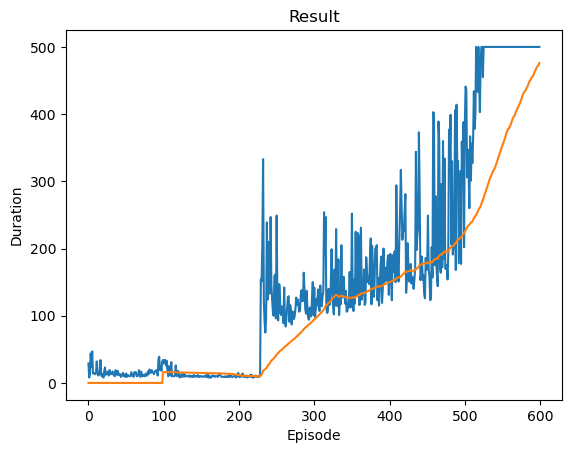

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

Here is the diagram that illustrates the overall resulting data flow.

![](https://pytorch.org/tutorials/_static/img/reinforcement_learning_diagram.jpg)

Actions are chosen either randomly or based on a policy, getting the
next step sample from the gym environment. We record the results in the
replay memory and also run optimization step on every iteration.
Optimization picks a random batch from the replay memory to do training
of the new policy. The \"older\" target\_net is also used in
optimization to compute the expected Q values. A soft update of its
weights are performed at every step.


### DQN Practice

In [ ]:
new = env.reset() # 4 real values to express env (pos, vel ,etc.)

In [ ]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("CartPole-v1")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"
)

# Replay memory is composed of transitions, generated by play, used for training. It has push, sample, len methods.
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity) # deque is list like data structure

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    
# DQN algorithm
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)
    
    # forward is used with one x to determine next action,
    # or during optimization with a batch of inputs.
    # returns tensor([[left0exp, right0exp], [left1exp, right1exp]...])
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x) # the value prediction is passed as it is
    
    # Training
BATCH_SIZE = 128
GAMMA = 0.99 # discount factor
EPS_START = 0.9 # high exploration at first
EPS_END = 0.05 # non-zero exploration later
EPD_DECAY = 1000 # 1000 steps for decaying
TAU = 0.005 # update rate of target network
LR = 1e-4 # learning rate of optimizer

# number of actions
n_actions = env.action_space.n

# number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations=n_observations, n_actions=n_actions).to(device)
target_net = DQN(n_observations=n_observations, n_actions=n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict()) # same initial parameters

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memoery = ReplayMemory(10000)

steps_done = 0

# action selection based on epsilon greedy
def select_action(state):
    global steps_done
    sample = random.random()
    esp_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > esp_threshold:
        with torch.no_grad():
            # max(0) is largest of the two values, max(1) is the index
            #
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

episode_durations = []

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

## Training
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

## Training loop



In [ ]:
for i_episode in range(10):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated: next_state = None
        else: next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        memory.push(state, action, next_state, reward)
        state = next_state

        if done:
            episode_durations.append(t+1)
            break

# Optimization

batch = Transition(*zip(*memory.sample(5)))

state_batch = torch.cat(batch.state)
action_batch = torch.cat(batch.action)
reward_batch = torch.cat(batch.reward)


non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])


In [ ]:
state_action_values = policy_net(state_batch).gather(1, action_batch)
state_action_values

tensor([[0.0863],
        [0.0938],
        [0.0910],
        [0.0911],
        [0.0877]], device='cuda:0', grad_fn=<GatherBackward0>)

In [ ]:
next_state_values = torch.zeros(5, device=device)
with torch.no_grad():
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
expected_state_action_values = (next_state_values * GAMMA) + reward_batch
expected_state_action_values

tensor([0.9998, 1.0111, 1.0079, 1.0035, 1.0022], device='cuda:0')

In [ ]:

state_action_values = policy_net(state_batch).gather(1, action_batch)

next_state_values = torch.zeros(5, device=device)
with torch.no_grad():
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
expected_state_action_values = (next_state_values * GAMMA) + reward_batch

criterion = nn.SmoothL1Loss()
loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
loss

optimizer.zero_grad()
loss.backward()
torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
optimizer.step()

## Reinforcement Learning (PPO) with TorchRL Tutorial

This tutorial demonstrates how to use PyTorch and
:py`torchrl`{.interpreted-text role="mod"} to train a parametric policy
network to solve the Inverted Pendulum task from the
[OpenAI-Gym/Farama-Gymnasium control
library](https://github.com/Farama-Foundation/Gymnasium).

![Inverted
pendulum](https://pytorch.org/tutorials/_static/img/invpendulum.gif)

Key learnings:

-   How to create an environment in TorchRL, transform its outputs, and
    collect data from this environment;
-   How to make your classes talk to each other using
    `~tensordict.TensorDict`{.interpreted-text role="class"};
-   The basics of building your training loop with TorchRL:
    -   How to compute the advantage signal for policy gradient methods;
    -   How to create a stochastic policy using a probabilistic neural
        network;
    -   How to create a dynamic replay buffer and sample from it without
        repetition.

We will cover six crucial components of TorchRL:

-   [environments](https://pytorch.org/rl/reference/envs.html)
-   [transforms](https://pytorch.org/rl/reference/envs.html#transforms)
-   [models (policy and value
    function)](https://pytorch.org/rl/reference/modules.html)
-   [loss modules](https://pytorch.org/rl/reference/objectives.html)
-   [data collectors](https://pytorch.org/rl/reference/collectors.html)
-   [replay
    buffers](https://pytorch.org/rl/reference/data.html#replay-buffers)


If you are running this in Google Colab, make sure you install the
following dependencies:

``` {.sourceCode .bash}
!pip3 install torchrl
!pip3 install gym[mujoco]
!pip3 install tqdm
```

Proximal Policy Optimization (PPO) is a policy-gradient algorithm where
a batch of data is being collected and directly consumed to train the
policy to maximise the expected return given some proximality
constraints. You can think of it as a sophisticated version of
[REINFORCE](https://link.springer.com/content/pdf/10.1007/BF00992696.pdf),
the foundational policy-optimization algorithm. For more information,
see the [Proximal Policy Optimization
Algorithms](https://arxiv.org/abs/1707.06347) paper.

PPO is usually regarded as a fast and efficient method for online,
on-policy reinforcement algorithm. TorchRL provides a loss-module that
does all the work for you, so that you can rely on this implementation
and focus on solving your problem rather than re-inventing the wheel
every time you want to train a policy.

For completeness, here is a brief overview of what the loss computes,
even though this is taken care of by our
`~torchrl.objectives.ClipPPOLoss`{.interpreted-text role="class"}
module---the algorithm works as follows: 1. we will sample a batch of
data by playing the policy in the environment for a given number of
steps. 2. Then, we will perform a given number of optimization steps
with random sub-samples of this batch using a clipped version of the
REINFORCE loss. 3. The clipping will put a pessimistic bound on our
loss: lower return estimates will be favored compared to higher ones.
The precise formula of the loss is:

$$L(s,a,\theta_k,\theta) = \min\left(
\frac{\pi_{\theta}(a|s)}{\pi_{\theta_k}(a|s)}  A^{\pi_{\theta_k}}(s,a), \;\;
g(\epsilon, A^{\pi_{\theta_k}}(s,a))
\right),$$

There are two components in that loss: in the first part of the minimum
operator, we simply compute an importance-weighted version of the
REINFORCE loss (for example, a REINFORCE loss that we have corrected for
the fact that the current policy configuration lags the one that was
used for the data collection). The second part of that minimum operator
is a similar loss where we have clipped the ratios when they exceeded or
were below a given pair of thresholds.

This loss ensures that whether the advantage is positive or negative,
policy updates that would produce significant shifts from the previous
configuration are being discouraged.

This tutorial is structured as follows:

1.  First, we will define a set of hyperparameters we will be using for
    training.
2.  Next, we will focus on creating our environment, or simulator, using
    TorchRL\'s wrappers and transforms.
3.  Next, we will design the policy network and the value model, which
    is indispensable to the loss function. These modules will be used to
    configure our loss module.
4.  Next, we will create the replay buffer and data loader.
5.  Finally, we will run our training loop and analyze the results.

Throughout this tutorial, we\'ll be using the
`tensordict`{.interpreted-text role="mod"} library.
`~tensordict.TensorDict`{.interpreted-text role="class"} is the lingua
franca of TorchRL: it helps us abstract what a module reads and writes
and care less about the specific data description and more about the
algorithm itself.


In [ ]:
import warnings
warnings.filterwarnings("ignore")
from torch import multiprocessing


from collections import defaultdict

import matplotlib.pyplot as plt
import torch
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import nn
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import (Compose, DoubleToFloat, ObservationNorm, StepCounter,
                          TransformedEnv)
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs.utils import check_env_specs, ExplorationType, set_exploration_type
from torchrl.modules import ProbabilisticActor, TanhNormal, ValueOperator
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
from tqdm import tqdm

### Define Hyperparameters

We set the hyperparameters for our algorithm. Depending on the resources
available, one may choose to execute the policy on GPU or on another
device. The `frame_skip` will control how for how many frames is a
single action being executed. The rest of the arguments that count
frames must be corrected for this value (since one environment step will
actually return `frame_skip` frames).


In [ ]:
is_fork = multiprocessing.get_start_method() == "fork"
device = (
    torch.device(0)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cpu")
)
num_cells = 256  # number of cells in each layer i.e. output dim.
lr = 3e-4
max_grad_norm = 1.0

### Data collection parameters

When collecting data, we will be able to choose how big each batch will
be by defining a `frames_per_batch` parameter. We will also define how
many frames (such as the number of interactions with the simulator) we
will allow ourselves to use. In general, the goal of an RL algorithm is
to learn to solve the task as fast as it can in terms of environment
interactions: the lower the `total_frames` the better.


In [ ]:
frames_per_batch = 1000
# For a complete training, bring the number of frames up to 1M
total_frames = 50_000

### PPO parameters

At each data collection (or batch collection) we will run the
optimization over a certain number of *epochs*, each time consuming the
entire data we just acquired in a nested training loop. Here, the
`sub_batch_size` is different from the `frames_per_batch` here above:
recall that we are working with a \"batch of data\" coming from our
collector, which size is defined by `frames_per_batch`, and that we will
further split in smaller sub-batches during the inner training loop. The
size of these sub-batches is controlled by `sub_batch_size`.


In [ ]:
sub_batch_size = 64  # cardinality of the sub-samples gathered from the current data in the inner loop
num_epochs = 10  # optimization steps per batch of data collected
clip_epsilon = (
    0.2  # clip value for PPO loss: see the equation in the intro for more context.
)
gamma = 0.99
lmbda = 0.95
entropy_eps = 1e-4

### Define an environment

In RL, an *environment* is usually the way we refer to a simulator or a
control system. Various libraries provide simulation environments for
reinforcement learning, including Gymnasium (previously OpenAI Gym),
DeepMind control suite, and many others. As a general library,
TorchRL\'s goal is to provide an interchangeable interface to a large
panel of RL simulators, allowing you to easily swap one environment with
another. For example, creating a wrapped gym environment can be achieved
with few characters:


In [ ]:
base_env = GymEnv("InvertedDoublePendulum-v4", device=device)

There are a few things to notice in this code: first, we created the
environment by calling the `GymEnv` wrapper. If extra keyword arguments
are passed, they will be transmitted to the `gym.make` method, hence
covering the most common environment construction commands.
Alternatively, one could also directly create a gym environment using
`gym.make(env_name, **kwargs)` and wrap it in a [GymWrapper]{.title-ref}
class.

Also the `device` argument: for gym, this only controls the device where
input action and observed states will be stored, but the execution will
always be done on CPU. The reason for this is simply that gym does not
support on-device execution, unless specified otherwise. For other
libraries, we have control over the execution device and, as much as we
can, we try to stay consistent in terms of storing and execution
backends.

### Transforms

We will append some transforms to our environments to prepare the data
for the policy. In Gym, this is usually achieved via wrappers. TorchRL
takes a different approach, more similar to other pytorch domain
libraries, through the use of transforms. To add transforms to an
environment, one should simply wrap it in a
`~torchrl.envs.transforms.TransformedEnv`{.interpreted-text
role="class"} instance and append the sequence of transforms to it. The
transformed environment will inherit the device and meta-data of the
wrapped environment, and transform these depending on the sequence of
transforms it contains.

### Normalization

The first to encode is a normalization transform. As a rule of thumbs,
it is preferable to have data that loosely match a unit Gaussian
distribution: to obtain this, we will run a certain number of random
steps in the environment and compute the summary statistics of these
observations.

We\'ll append two other transforms: the
`~torchrl.envs.transforms.DoubleToFloat`{.interpreted-text role="class"}
transform will convert double entries to single-precision numbers, ready
to be read by the policy. The
`~torchrl.envs.transforms.StepCounter`{.interpreted-text role="class"}
transform will be used to count the steps before the environment is
terminated. We will use this measure as a supplementary measure of
performance.

As we will see later, many of the TorchRL\'s classes rely on
`~tensordict.TensorDict`{.interpreted-text role="class"} to communicate.
You could think of it as a python dictionary with some extra tensor
features. In practice, this means that many modules we will be working
with need to be told what key to read (`in_keys`) and what key to write
(`out_keys`) in the `tensordict` they will receive. Usually, if
`out_keys` is omitted, it is assumed that the `in_keys` entries will be
updated in-place. For our transforms, the only entry we are interested
in is referred to as `"observation"` and our transform layers will be
told to modify this entry and this entry only:


In [ ]:
env = TransformedEnv(
    base_env,
    Compose(
        # normalize observations
        ObservationNorm(in_keys=["observation"]),
        DoubleToFloat(),
        StepCounter(),
    ),
)

As you may have noticed, we have created a normalization layer but we
did not set its normalization parameters. To do this,
`~torchrl.envs.transforms.ObservationNorm`{.interpreted-text
role="class"} can automatically gather the summary statistics of our
environment:


In [ ]:
env.transform[0].init_stats(num_iter=1000, reduce_dim=0, cat_dim=0)

The `~torchrl.envs.transforms.ObservationNorm`{.interpreted-text
role="class"} transform has now been populated with a location and a
scale that will be used to normalize the data.

Let us do a little sanity check for the shape of our summary stats:


In [ ]:
print("normalization constant shape:", env.transform[0].loc.shape)

normalization constant shape: torch.Size([11])


An environment is not only defined by its simulator and transforms, but
also by a series of metadata that describe what can be expected during
its execution. For efficiency purposes, TorchRL is quite stringent when
it comes to environment specs, but you can easily check that your
environment specs are adequate. In our example, the
`~torchrl.envs.libs.gym.GymWrapper`{.interpreted-text role="class"} and
`~torchrl.envs.libs.gym.GymEnv`{.interpreted-text role="class"} that
inherits from it already take care of setting the proper specs for your
environment so you should not have to care about this.

Nevertheless, let\'s see a concrete example using our transformed
environment by looking at its specs. There are three specs to look at:
`observation_spec` which defines what is to be expected when executing
an action in the environment, `reward_spec` which indicates the reward
domain and finally the `input_spec` (which contains the `action_spec`)
and which represents everything an environment requires to execute a
single step.


In [ ]:
print("observation_spec:", env.observation_spec)
print("reward_spec:", env.reward_spec)
print("input_spec:", env.input_spec)
print("action_spec (as defined by input_spec):", env.action_spec)

observation_spec: CompositeSpec(
    observation: UnboundedContinuousTensorSpec(
        shape=torch.Size([11]),
        space=None,
        device=cuda:0,
        dtype=torch.float32,
        domain=continuous),
    step_count: BoundedTensorSpec(
        shape=torch.Size([1]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.int64, contiguous=True),
            high=Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.int64, contiguous=True)),
        device=cuda:0,
        dtype=torch.int64,
        domain=continuous), device=cuda:0, shape=torch.Size([]))
reward_spec: UnboundedContinuousTensorSpec(
    shape=torch.Size([1]),
    space=ContinuousBox(
        low=Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, contiguous=True),
        high=Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, contiguous=True)),
    device=cuda:0,
    dtype=torch.float32,
    domain=continuous)
input_spec: CompositeS

the `check_env_specs`{.interpreted-text role="func"} function runs a
small rollout and compares its output against the environment specs. If
no error is raised, we can be confident that the specs are properly
defined:


In [ ]:
check_env_specs(env)

2024-07-11 20:28:55,992 [torchrl][INFO] check_env_specs succeeded!


For fun, let\'s see what a simple random rollout looks like. You can
call [env.rollout(n\_steps)]{.title-ref} and get an overview of what the
environment inputs and outputs look like. Actions will automatically be
drawn from the action spec domain, so you don\'t need to care about
designing a random sampler.

Typically, at each step, an RL environment receives an action as input,
and outputs an observation, a reward and a done state. The observation
may be composite, meaning that it could be composed of more than one
tensor. This is not a problem for TorchRL, since the whole set of
observations is automatically packed in the output
`~tensordict.TensorDict`{.interpreted-text role="class"}. After
executing a rollout (for example, a sequence of environment steps and
random action generations) over a given number of steps, we will
retrieve a `~tensordict.TensorDict`{.interpreted-text role="class"}
instance with a shape that matches this trajectory length:


In [ ]:
rollout = env.rollout(3)
print("rollout of three steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)

rollout of three steps: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        done: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
                observation: Tensor(shape=torch.Size([3, 11]), device=cuda:0, dtype=torch.float32, is_shared=True),
                reward: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                step_count: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.int64, is_shared=True),
                terminated: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
                truncated: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.bool, is_shared=True)},
            batch_size=torch.Size([3]),


Our rollout data has a shape of `torch.Size([3])`, which matches the
number of steps we ran it for. The `"next"` entry points to the data
coming after the current step. In most cases, the `"next"` data at time
[t]{.title-ref} matches the data at `t+1`, but this may not be the case
if we are using some specific transformations (for example, multi-step).

### Policy

PPO utilizes a stochastic policy to handle exploration. This means that
our neural network will have to output the parameters of a distribution,
rather than a single value corresponding to the action taken.

As the data is continuous, we use a Tanh-Normal distribution to respect
the action space boundaries. TorchRL provides such distribution, and the
only thing we need to care about is to build a neural network that
outputs the right number of parameters for the policy to work with (a
location, or mean, and a scale):

$$f_{\theta}(\text{observation}) = \mu_{\theta}(\text{observation}), \sigma^{+}_{\theta}(\text{observation})$$

The only extra-difficulty that is brought up here is to split our output
in two equal parts and map the second to a strictly positive space.

We design the policy in three steps:

1.  Define a neural network `D_obs` -\> `2 * D_action`. Indeed, our
    `loc` (mu) and `scale` (sigma) both have dimension `D_action`.
2.  Append a
    `~tensordict.nn.distributions.NormalParamExtractor`{.interpreted-text
    role="class"} to extract a location and a scale (for example, splits
    the input in two equal parts and applies a positive transformation
    to the scale parameter).
3.  Create a probabilistic
    `~tensordict.nn.TensorDictModule`{.interpreted-text role="class"}
    that can generate this distribution and sample from it.


In [ ]:
actor_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(2 * env.action_spec.shape[-1], device=device),
    NormalParamExtractor(),
)

To enable the policy to \"talk\" with the environment through the
`tensordict` data carrier, we wrap the `nn.Module` in a
`~tensordict.nn.TensorDictModule`{.interpreted-text role="class"}. This
class will simply ready the `in_keys` it is provided with and write the
outputs in-place at the registered `out_keys`.


In [ ]:
policy_module = TensorDictModule(
    actor_net, in_keys=["observation"], out_keys=["loc", "scale"]
)

We now need to build a distribution out of the location and scale of our
normal distribution. To do so, we instruct the
`~torchrl.modules.tensordict_module.ProbabilisticActor`{.interpreted-text
role="class"} class to build a
`~torchrl.modules.TanhNormal`{.interpreted-text role="class"} out of the
location and scale parameters. We also provide the minimum and maximum
values of this distribution, which we gather from the environment specs.

The name of the `in_keys` (and hence the name of the `out_keys` from the
`~tensordict.nn.TensorDictModule`{.interpreted-text role="class"} above)
cannot be set to any value one may like, as the
`~torchrl.modules.TanhNormal`{.interpreted-text role="class"}
distribution constructor will expect the `loc` and `scale` keyword
arguments. That being said,
`~torchrl.modules.tensordict_module.ProbabilisticActor`{.interpreted-text
role="class"} also accepts `Dict[str, str]` typed `in_keys` where the
key-value pair indicates what `in_key` string should be used for every
keyword argument that is to be used.


In [ ]:
policy_module = ProbabilisticActor(
    module=policy_module,
    spec=env.action_spec,
    in_keys=["loc", "scale"],
    distribution_class=TanhNormal,
    distribution_kwargs={
        "min": env.action_spec.space.low,
        "max": env.action_spec.space.high,
    },
    return_log_prob=True,
    # we'll need the log-prob for the numerator of the importance weights
)

### Value network

The value network is a crucial component of the PPO algorithm, even
though it won\'t be used at inference time. This module will read the
observations and return an estimation of the discounted return for the
following trajectory. This allows us to amortize learning by relying on
the some utility estimation that is learned on-the-fly during training.
Our value network share the same structure as the policy, but for
simplicity we assign it its own set of parameters.


In [ ]:
value_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(1, device=device),
)

value_module = ValueOperator(
    module=value_net,
    in_keys=["observation"],
)

let\'s try our policy and value modules. As we said earlier, the usage
of `~tensordict.nn.TensorDictModule`{.interpreted-text role="class"}
makes it possible to directly read the output of the environment to run
these modules, as they know what information to read and where to write
it:


In [ ]:
print("Running policy:", policy_module(env.reset()))
print("Running value:", value_module(env.reset()))

Running policy: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        done: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        loc: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        observation: Tensor(shape=torch.Size([11]), device=cuda:0, dtype=torch.float32, is_shared=True),
        sample_log_prob: Tensor(shape=torch.Size([]), device=cuda:0, dtype=torch.float32, is_shared=True),
        scale: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        step_count: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.int64, is_shared=True),
        terminated: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        truncated: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True)},
    batch_size=torch.Size([]),
    device=cuda:0,
    is_sh

### Data collector

TorchRL provides a set of [DataCollector
classes](https://pytorch.org/rl/reference/collectors.html). Briefly,
these classes execute three operations: reset an environment, compute an
action given the latest observation, execute a step in the environment,
and repeat the last two steps until the environment signals a stop (or
reaches a done state).

They allow you to control how many frames to collect at each iteration
(through the `frames_per_batch` parameter), when to reset the
environment (through the `max_frames_per_traj` argument), on which
`device` the policy should be executed, etc. They are also designed to
work efficiently with batched and multiprocessed environments.

The simplest data collector is the
`~torchrl.collectors.collectors.SyncDataCollector`{.interpreted-text
role="class"}: it is an iterator that you can use to get batches of data
of a given length, and that will stop once a total number of frames
(`total_frames`) have been collected. Other data collectors
(`~torchrl.collectors.collectors.MultiSyncDataCollector`{.interpreted-text
role="class"} and
`~torchrl.collectors.collectors.MultiaSyncDataCollector`{.interpreted-text
role="class"}) will execute the same operations in synchronous and
asynchronous manner over a set of multiprocessed workers.

As for the policy and environment before, the data collector will return
`~tensordict.TensorDict`{.interpreted-text role="class"} instances with
a total number of elements that will match `frames_per_batch`. Using
`~tensordict.TensorDict`{.interpreted-text role="class"} to pass data to
the training loop allows you to write data loading pipelines that are
100% oblivious to the actual specificities of the rollout content.


In [ ]:
collector = SyncDataCollector(
    env,
    policy_module,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
    split_trajs=False,
    device=device,
)

### Replay buffer

Replay buffers are a common building piece of off-policy RL algorithms.
In on-policy contexts, a replay buffer is refilled every time a batch of
data is collected, and its data is repeatedly consumed for a certain
number of epochs.

TorchRL\'s replay buffers are built using a common container
`~torchrl.data.ReplayBuffer`{.interpreted-text role="class"} which takes
as argument the components of the buffer: a storage, a writer, a sampler
and possibly some transforms. Only the storage (which indicates the
replay buffer capacity) is mandatory. We also specify a sampler without
repetition to avoid sampling multiple times the same item in one epoch.
Using a replay buffer for PPO is not mandatory and we could simply
sample the sub-batches from the collected batch, but using these classes
make it easy for us to build the inner training loop in a reproducible
way.


In [ ]:
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(max_size=frames_per_batch),
    sampler=SamplerWithoutReplacement(),
)

### Loss function

The PPO loss can be directly imported from TorchRL for convenience using
the `~torchrl.objectives.ClipPPOLoss`{.interpreted-text role="class"}
class. This is the easiest way of utilizing PPO: it hides away the
mathematical operations of PPO and the control flow that goes with it.

PPO requires some \"advantage estimation\" to be computed. In short, an
advantage is a value that reflects an expectancy over the return value
while dealing with the bias / variance tradeoff. To compute the
advantage, one just needs to (1) build the advantage module, which
utilizes our value operator, and (2) pass each batch of data through it
before each epoch. The GAE module will update the input `tensordict`
with new `"advantage"` and `"value_target"` entries. The
`"value_target"` is a gradient-free tensor that represents the empirical
value that the value network should represent with the input
observation. Both of these will be used by
`~torchrl.objectives.ClipPPOLoss`{.interpreted-text role="class"} to
return the policy and value losses.


In [ ]:
advantage_module = GAE(
    gamma=gamma, lmbda=lmbda, value_network=value_module, average_gae=True
)

loss_module = ClipPPOLoss(
    actor_network=policy_module,
    critic_network=value_module,
    clip_epsilon=clip_epsilon,
    entropy_bonus=bool(entropy_eps),
    entropy_coef=entropy_eps,
    # these keys match by default but we set this for completeness
    critic_coef=1.0,
    loss_critic_type="smooth_l1",
)

optim = torch.optim.Adam(loss_module.parameters(), lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim, total_frames // frames_per_batch, 0.0
)

### Training loop

We now have all the pieces needed to code our training loop. The steps
include:

-   Collect data
    -   Compute advantage
        -   Loop over the collected to compute loss values
        -   Back propagate
        -   Optimize
        -   Repeat
    -   Repeat
-   Repeat


In [ ]:
logs = defaultdict(list)
pbar = tqdm(total=total_frames)
eval_str = ""

# We iterate over the collector until it reaches the total number of frames it was
# designed to collect:
for i, tensordict_data in enumerate(collector):
    # we now have a batch of data to work with. Let's learn something from it.
    for _ in range(num_epochs):
        # We'll need an "advantage" signal to make PPO work.
        # We re-compute it at each epoch as its value depends on the value
        # network which is updated in the inner loop.
        advantage_module(tensordict_data)
        data_view = tensordict_data.reshape(-1)
        replay_buffer.extend(data_view.cpu())
        for _ in range(frames_per_batch // sub_batch_size):
            subdata = replay_buffer.sample(sub_batch_size)
            loss_vals = loss_module(subdata.to(device))
            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            # Optimization: backward, grad clipping and optimization step
            loss_value.backward()
            # this is not strictly mandatory but it's good practice to keep
            # your gradient norm bounded
            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            optim.step()
            optim.zero_grad()

    logs["reward"].append(tensordict_data["next", "reward"].mean().item())
    pbar.update(tensordict_data.numel())
    cum_reward_str = (
        f"average reward={logs['reward'][-1]: 4.4f} (init={logs['reward'][0]: 4.4f})"
    )
    logs["step_count"].append(tensordict_data["step_count"].max().item())
    stepcount_str = f"step count (max): {logs['step_count'][-1]}"
    logs["lr"].append(optim.param_groups[0]["lr"])
    lr_str = f"lr policy: {logs['lr'][-1]: 4.4f}"
    if i % 10 == 0:
        # We evaluate the policy once every 10 batches of data.
        # Evaluation is rather simple: execute the policy without exploration
        # (take the expected value of the action distribution) for a given
        # number of steps (1000, which is our ``env`` horizon).
        # The ``rollout`` method of the ``env`` can take a policy as argument:
        # it will then execute this policy at each step.
        with set_exploration_type(ExplorationType.MEAN), torch.no_grad():
            # execute a rollout with the trained policy
            eval_rollout = env.rollout(1000, policy_module)
            logs["eval reward"].append(eval_rollout["next", "reward"].mean().item())
            logs["eval reward (sum)"].append(
                eval_rollout["next", "reward"].sum().item()
            )
            logs["eval step_count"].append(eval_rollout["step_count"].max().item())
            eval_str = (
                f"eval cumulative reward: {logs['eval reward (sum)'][-1]: 4.4f} "
                f"(init: {logs['eval reward (sum)'][0]: 4.4f}), "
                f"eval step-count: {logs['eval step_count'][-1]}"
            )
            del eval_rollout
    pbar.set_description(", ".join([eval_str, cum_reward_str, stepcount_str, lr_str]))

    # We're also using a learning rate scheduler. Like the gradient clipping,
    # this is a nice-to-have but nothing necessary for PPO to work.
    scheduler.step()

eval cumulative reward:  91.9957 (init:  91.9957), eval step-count: 9, average reward=9.2303(init=9.0693), step count (max): 32, lr policy:  0.0003:  14%|█▍        | 7000/50000 [00:33<03:24, 210.36it/s]
eval cumulative reward:  1344.8938 (init:  250.7185), eval step-count: 143, average reward= 9.3147 (init= 9.2526), step count (max): 111, lr policy:  0.0000:  84%|████████▍ | 42000/50000 [02:32<00:31, 253.02it/s]

eval cumulative reward:  1344.8938 (init:  250.7185), eval step-count: 143, average reward= 9.3147 (init= 9.2526), step count (max): 111, lr policy:  0.0000:  84%|████████▍ | 42000/50000 [02:44<00:31, 253.02it/s]

### Results

Before the 1M step cap is reached, the algorithm should have reached a
max step count of 1000 steps, which is the maximum number of steps
before the trajectory is truncated.


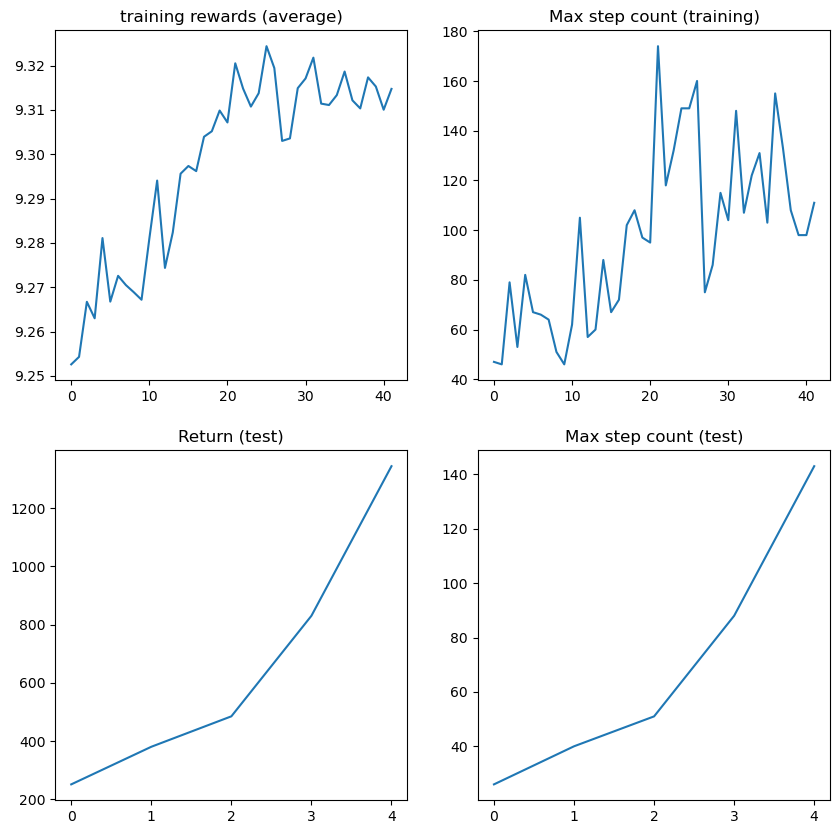

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(logs["reward"])
plt.title("training rewards (average)")
plt.subplot(2, 2, 2)
plt.plot(logs["step_count"])
plt.title("Max step count (training)")
plt.subplot(2, 2, 3)
plt.plot(logs["eval reward (sum)"])
plt.title("Return (test)")
plt.subplot(2, 2, 4)
plt.plot(logs["eval step_count"])
plt.title("Max step count (test)")
plt.show()

### Conclusion and next steps

In this tutorial, we have learned:

1.  How to create and customize an environment with
    :py`torchrl`{.interpreted-text role="mod"};
2.  How to write a model and a loss function;
3.  How to set up a typical training loop.

If you want to experiment with this tutorial a bit more, you can apply
the following modifications:

-   From an efficiency perspective, we could run several simulations in
    parallel to speed up data collection. Check
    `~torchrl.envs.ParallelEnv`{.interpreted-text role="class"} for
    further information.
-   From a logging perspective, one could add a
    `torchrl.record.VideoRecorder`{.interpreted-text role="class"}
    transform to the environment after asking for rendering to get a
    visual rendering of the inverted pendulum in action. Check
    :py`torchrl.record`{.interpreted-text role="mod"} to know more.


### PPO Practice

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from torch import multiprocessing


from collections import defaultdict

import matplotlib.pyplot as plt
import torch
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import nn
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import (Compose, DoubleToFloat, ObservationNorm, StepCounter,
                          TransformedEnv)
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs.utils import check_env_specs, ExplorationType, set_exploration_type
from torchrl.modules import ProbabilisticActor, TanhNormal, ValueOperator
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
from tqdm import tqdm

In [ ]:
# 1. Hyperparameters
is_fork = multiprocessing.get_start_method() == "fork"
device = (
    torch.device(0)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cpu")
)
num_cells = 256  # number of cells in each layer i.e. output dim.
lr = 3e-4
max_grad_norm = 1.0

# 1.1 Data collection parameters
frames_per_batch = 1000
total_frames = 50_000

# 1.2 PPO parameters
sub_batch_size = 64  # frame per batch will be subdivided
num_epochs = 10  # optimization steps per batch of data collected
clip_epsilon = (
    0.2  # clip value for PPO loss: see the equation in the intro for more context.
)
gamma = 0.99
lmbda = 0.95
entropy_eps = 1e-4

# 2. Create environment using TorchRL wrappers and transforms.
base_env = GymEnv("InvertedDoublePendulum-v4", device=device)

# 2.1Transforms
# Wrap sequence of transforms in a torchrl.envs.transforms.TransformedEnv
# Normalization - first transform. Also DoubltToFloat and StepCounter
env = TransformedEnv(
    base_env,
    Compose(
        # normalize observations
        ObservationNorm(in_keys=["observation"]),
        DoubleToFloat(),
        StepCounter(),
    ),
)

env.transform[0].init_stats(num_iter=1000, reduce_dim=0, cat_dim=0)

# 3. Policy network and value model > loss module
# 3.1 Policy: for PPO, the neural network will have to output parameters of a distribution.
# Tanh-normal distribution for continuous data
# neural_network(observation) = loc(observation), scale(observation), both having dimension of D_action
# tensordict.nn.distributions.NormalParamExtractor for extracting location and scale.
# tensordict.nn.TensorDictModule can generate distribution and sample from it
actor_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(2 * env.action_spec.shape[-1], device=device),
    NormalParamExtractor(),
)

# the policy will talk to env with tensordict in_keys and out_keys
policy_module = TensorDictModule(
    actor_net,
    in_keys=["observation"],
    out_keys=["loc", "scale"]
)
# action distribution using ~torchrl.modules.tensordict_module.ProbabilisticActor class to build ~torchrl.modules.TanhNormal
policy_module = ProbabilisticActor(
    module=policy_module,
    spec=env.action_spec,
    in_keys=["loc", "scale"],
    distribution_class=TanhNormal,
    distribution_kwargs={
        "min": env.action_spec.space.low,
        "max": env.action_spec.space.high,
    },
    return_log_prob=True,
 )
# 3.2 Value network - is not used for inference.
# Returns estimation of discounted return of following trajectory for given observation.
value_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(1, device=device),
)
value_module = ValueOperator(
    module=value_net,
    in_keys=["observation"],
)

print("Running policy:", policy_module(env.reset()))
print("Running value:", value_module(env.reset()))

# 4. Data collector

# 4.1data collector classes execute three operations: reset env,
# compute action given latest observation, execute a stepin env
# - repeat first 2 steps until stop.
# how many frames to collect at each iteration: frames_per_batch
# when to reset env: max_frames_per_traj, device to execute
# simplest data collector: torchrl.collectors.collectors.SyncDataCollector
# - iterator that gives batches of data of given length, stops if total_frames have been collected.
# synchronous: torchrl.collectors.collectors.MultiSyncDataCollector
# asynchronous: torchrl.collectors.collectors.MultiaSyncDataCollector
# the data collector will return ~tensordict.TensorDict instance with
# total number of elements equal to frames_per_batch
collector = SyncDataCollector(
    env,
    policy_module,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
    split_trajs=False,
    device=device,
)

# 4.2 Replay buffer
# common building piece of off-policy RL.
# in on-policy, data is updated and consumed with data collection.
# torchrl.data.ReplayBuffer takes components of buffer as argument:
# a storage, a writer, a sampler, some transforms
# sampleWithoutReplacement(), don't sample same data multiple times in an epoch
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(max_size=frames_per_batch),
    sampler=SamplerWithoutReplacement(),
)

# 5. Training loop, result analysis
# 5.1 loss function
# PPO loss from torchRL: torchrl.objectives.ClipPPOLoss class
# PPO requires "advantage estimation" to be computed - which reflects
# expectancy over the return value while dealing with bias/variance tradeoff.

# to compute advantage - 1. build advantage module that utilizes value operator
# 2. pass each batch of data through it before each epoch
# the GAE module will update the input tensordict with new "advantage"
# and "value_target" entries.
# The "value_target" is a gradient free tensor that represents the empirical 
# value that the value network should represent with the input observation
# the "advantage" and "value_target" will be used by 
# torchrl.objectives.ClipPPOLoss to return the policy and value losses.

advantage_module = GAE(
    gamma=gamma, lmbda=lmbda, value_network=value_module, average_gae=True
)

loss_module = ClipPPOLoss(
    actor_network=policy_module,
    critic_network=value_module,
    clip_epsilon=clip_epsilon,
    entropy_bonus=bool(entropy_eps),
    entropy_coef=entropy_eps,
    # these keys match by default but we set this for completeness
    critic_coef=1.0,
    loss_critic_type="smooth_l1",
)

optim = torch.optim.Adam(loss_module.parameters(), lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim, total_frames // frames_per_batch, 0.0
)

#5.2 Training loop - steps:
# collect data
    # compute advantage
        # loop over the data to compute loss values
        # back propagate
        # optimize
        # repeat
    # repeat
# repeat


In [ ]:

logs = defaultdict(list)
pbar = tqdm(total=total_frames)
eval_str = ""

# iterate over collector until it reaches total_frames
for i, tensordict_data in enumerate(collector):
    for _ in range(num_epochs):
        # we need "advantage" signal for PPO
        # it's based on value-network, and is recomputed
        # at each epoch with update of value-network
        advantage_module(tensordict_data)
        data_view = tensordict_data.reshape(-1)
        replay_buffer.extend(data_view.cpu())
        for _ in range(frames_per_batch // sub_batch_size):
            subdata = replay_buffer.sample(sub_batch_size)
            loss_vals = loss_module(subdata.to(device))
            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            # optimization: backward, grad clipping, optimization step
            loss_value.backward()
            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            optim.step()
            optim.zero_grad()
    
    logs["reward"].append(tensordict_data["next", "reward"].mean().item())
    pbar.update(tensordict_data.numel())
    cum_reward_str = (
        f"average reward={logs['reward'][-1]:4.4f}(init={logs['reward'][0]:4.4f})"
    )
    logs["step_count"].append(tensordict_data["step_count"].max().item())
    stepcount_str = f"step count (max): {logs['step_count'][-1]}"
    logs["lr"].append(optim.param_groups[0]["lr"])
    lr_str = f"lr policy: {logs['lr'][-1]: 4.4f}"
    if i % 10 == 0:
        # We evaluate the policy once every 10 batches of data.
        # Evaluation is rather simple: execute the policy without exploration
        # (take the expected value of the action distribution) for a given
        # number of steps (1000, which is our ``env`` horizon).
        # The ``rollout`` method of the ``env`` can take a policy as argument:
        # it will then execute this policy at each step.
        with set_exploration_type(ExplorationType.MEAN), torch.no_grad():
            # execute a rollout with the trained policy
            eval_rollout = env.rollout(1000, policy_module)
            logs["eval reward"].append(eval_rollout["next", "reward"].mean().item())
            logs["eval reward (sum)"].append(
                eval_rollout["next", "reward"].sum().item()
            )
            logs["eval step_count"].append(eval_rollout["step_count"].max().item())
            eval_str = (
                f"eval cumulative reward: {logs['eval reward (sum)'][-1]: 4.4f} "
                f"(init: {logs['eval reward (sum)'][0]: 4.4f}), "
                f"eval step-count: {logs['eval step_count'][-1]}"
            )
            del eval_rollout
    pbar.set_description(", ".join([eval_str, cum_reward_str, stepcount_str, lr_str]))

    # We're also using a learning rate scheduler. Like the gradient clipping,
    # this is a nice-to-have but nothing necessary for PPO to work.
    scheduler.step()


In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(logs["reward"])
plt.title("training rewards (average)")
plt.subplot(2, 2, 2)
plt.plot(logs["step_count"])
plt.title("Max step count (training)")
plt.subplot(2, 2, 3)
plt.plot(logs["eval reward (sum)"])
plt.title("Return (test)")
plt.subplot(2, 2, 4)
plt.plot(logs["eval step_count"])
plt.title("Max step count (test)")
plt.show()

## Mario Playing RL Agent

This tutorial walks you through the fundamentals of Deep Reinforcement
Learning. At the end, you will implement an AI-powered Mario (using
[Double Deep Q-Networks](https://arxiv.org/pdf/1509.06461.pdf)) that can
play the game by itself.

Although no prior knowledge of RL is necessary for this tutorial, you
can familiarize yourself with these RL
[concepts](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html),
and have this handy
[cheatsheet](https://colab.research.google.com/drive/1eN33dPVtdPViiS1njTW_-r-IYCDTFU7N)
as your companion. The full code is available
[here](https://github.com/yuansongFeng/MadMario/).

![](https://pytorch.org/tutorials/_static/img/mario.gif)


In [ ]:
``` {.sourceCode .bash}
%%bash
pip install gym-super-mario-bros==7.4.0
pip install tensordict==0.3.0
pip install torchrl==0.3.0
```


In [ ]:
import torch
from torch import nn
from torchvision import transforms as T
from PIL import Image
import numpy as np
from pathlib import Path
from collections import deque
import random, datetime, os

# Gym is an OpenAI toolkit for RL
import gym
from gym.spaces import Box
from gym.wrappers import FrameStack

# NES Emulator for OpenAI Gym
from nes_py.wrappers import JoypadSpace

# Super Mario environment for OpenAI Gym
import gym_super_mario_bros

from tensordict import TensorDict
from torchrl.data import TensorDictReplayBuffer, LazyMemmapStorage

### RL Definitions

**Environment** The world that an agent interacts with and learns from.

**Action** $a$ : How the Agent responds to the Environment. The set of
all possible Actions is called *action-space*.

**State** $s$ : The current characteristic of the Environment. The set
of all possible States the Environment can be in is called
*state-space*.

**Reward** $r$ : Reward is the key feedback from Environment to Agent.
It is what drives the Agent to learn and to change its future action. An
aggregation of rewards over multiple time steps is called **Return**.

**Optimal Action-Value function** $Q^*(s,a)$ : Gives the expected return
if you start in state $s$, take an arbitrary action $a$, and then for
each future time step take the action that maximizes returns. $Q$ can be
said to stand for the "quality" of the action in a state. We try to
approximate this function.


### Environment


#### Initialize Environment

In Mario, the environment consists of tubes, mushrooms and other
components.

When Mario makes an action, the environment responds with the changed
(next) state, reward and other info.


In [ ]:
gym.__version__

'0.26.2'

In [ ]:
# Initialize Super Mario environment (in v0.26 change render mode to 'human' to see results on the screen)
if gym.__version__ < '0.26':
    env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", new_step_api=True)
else:
    env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", render_mode='rgb', apply_api_compatibility=True)

# Limit the action-space to
#   0. walk right
#   1. jump right
env = JoypadSpace(env, [["right"], ["right", "A"]])

env.reset()
next_state, reward, done, trunc, info = env.step(action=0)
print(f"{next_state.shape},\n {reward},\n {done},\n {info}")

/home/sunzid/anaconda3/lib/python3.11/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/home/sunzid/anaconda3/lib/python3.11/site-packages/gym/envs/registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(


(240, 256, 3),
 0.0,
 False,
 {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'y_pos': 79}


/home/sunzid/anaconda3/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


### Preprocess Environment

Environment data is returned to the agent in `next_state`. As you saw
above, each state is represented by a `[3, 240, 256]` size array. Often
that is more information than our agent needs; for instance, Mario's
actions do not depend on the color of the pipes or the sky!

We use **Wrappers** to preprocess environment data before sending it to
the agent.

`GrayScaleObservation` is a common wrapper to transform an RGB image to
grayscale; doing so reduces the size of the state representation without
losing useful information. Now the size of each state: `[1, 240, 256]`

`ResizeObservation` downsamples each observation into a square image.
New size: `[1, 84, 84]`

`SkipFrame` is a custom wrapper that inherits from `gym.Wrapper` and
implements the `step()` function. Because consecutive frames don't vary
much, we can skip n-intermediate frames without losing much information.
The n-th frame aggregates rewards accumulated over each skipped frame.

`FrameStack` is a wrapper that allows us to squash consecutive frames of
the environment into a single observation point to feed to our learning
model. This way, we can identify if Mario was landing or jumping based
on the direction of his movement in the previous several frames.


In [ ]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, trunk, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, trunk, info


class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        return observation


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transforms = T.Compose(
            [T.Resize(self.shape, antialias=True), T.Normalize(0, 255)]
        )
        observation = transforms(observation).squeeze(0)
        return observation


# Apply Wrappers to environment
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
if gym.__version__ < '0.26':
    env = FrameStack(env, num_stack=4, new_step_api=True)
else:
    env = FrameStack(env, num_stack=4)

After applying the above wrappers to the environment, the final wrapped
state consists of 4 gray-scaled consecutive frames stacked together, as
shown above in the image on the left. Each time Mario makes an action,
the environment responds with a state of this structure. The structure
is represented by a 3-D array of size `[4, 84, 84]`.

![](https://pytorch.org/tutorials/_static/img/mario_env.png)


### Agent

We create a class `Mario` to represent our agent in the game. Mario
should be able to:

-   **Act** according to the optimal action policy based on the current
    state (of the environment).
-   **Remember** experiences. Experience = (current state, current
    action, reward, next state). Mario *caches* and later *recalls* his
    experiences to update his action policy.
-   **Learn** a better action policy over time


In [ ]:
class Mario:
    def __init__():
        pass

    def act(self, state):
        """Given a state, choose an epsilon-greedy action"""
        pass

    def cache(self, experience):
        """Add the experience to memory"""
        pass

    def recall(self):
        """Sample experiences from memory"""
        pass

    def learn(self):
        """Update online action value (Q) function with a batch of experiences"""
        pass

#### Act

For any given state, an agent can choose to do the most optimal action
(**exploit**) or a random action (**explore**).

Mario randomly explores with a chance of `self.exploration_rate`; when
he chooses to exploit, he relies on `MarioNet` (implemented in `Learn`
section) to provide the most optimal action.


In [ ]:
class Mario:
    def __init__(self, state_dim, action_dim, save_dir):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.save_dir = save_dir

        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        # Mario's DNN to predict the most optimal action - we implement this in the Learn section
        self.net = MarioNet(self.state_dim, self.action_dim).float()
        self.net = self.net.to(device=self.device)

        self.exploration_rate = 1
        self.exploration_rate_decay = 0.99999975
        self.exploration_rate_min = 0.1
        self.curr_step = 0

        self.save_every = 5e5  # no. of experiences between saving Mario Net

    def act(self, state):
        """
    Given a state, choose an epsilon-greedy action and update value of step.

    Inputs:
    state(``LazyFrame``): A single observation of the current state, dimension is (state_dim)
    Outputs:
    ``action_idx`` (``int``): An integer representing which action Mario will perform
    """
        # EXPLORE
        if np.random.rand() < self.exploration_rate:
            action_idx = np.random.randint(self.action_dim)

        # EXPLOIT
        else:
            state = state[0].__array__() if isinstance(state, tuple) else state.__array__()
            state = torch.tensor(state, device=self.device).unsqueeze(0)
            action_values = self.net(state, model="online")
            action_idx = torch.argmax(action_values, axis=1).item()

        # decrease exploration_rate
        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)

        # increment step
        self.curr_step += 1
        return action_idx

#### Cache and Recall

These two functions serve as Mario's "memory" process.

`cache()`: Each time Mario performs an action, he stores the
`experience` to his memory. His experience includes the current *state*,
*action* performed, *reward* from the action, the *next state*, and
whether the game is *done*.

`recall()`: Mario randomly samples a batch of experiences from his
memory, and uses that to learn the game.


In [ ]:
class Mario(Mario):  # subclassing for continuity
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.memory = TensorDictReplayBuffer(storage=LazyMemmapStorage(100000, device=torch.device("cpu")))
        self.batch_size = 32

    def cache(self, state, next_state, action, reward, done):
        """
        Store the experience to self.memory (replay buffer)

        Inputs:
        state (``LazyFrame``),
        next_state (``LazyFrame``),
        action (``int``),
        reward (``float``),
        done(``bool``))
        """
        def first_if_tuple(x):
            return x[0] if isinstance(x, tuple) else x
        state = first_if_tuple(state).__array__()
        next_state = first_if_tuple(next_state).__array__()

        state = torch.tensor(state)
        next_state = torch.tensor(next_state)
        action = torch.tensor([action])
        reward = torch.tensor([reward])
        done = torch.tensor([done])

        # self.memory.append((state, next_state, action, reward, done,))
        self.memory.add(TensorDict({"state": state, "next_state": next_state, "action": action, "reward": reward, "done": done}, batch_size=[]))

    def recall(self):
        """
        Retrieve a batch of experiences from memory
        """
        batch = self.memory.sample(self.batch_size).to(self.device)
        state, next_state, action, reward, done = (batch.get(key) for key in ("state", "next_state", "action", "reward", "done"))
        return state, next_state, action.squeeze(), reward.squeeze(), done.squeeze()

#### Learn

Mario uses the [DDQN algorithm](https://arxiv.org/pdf/1509.06461) under
the hood. DDQN uses two ConvNets - $Q_{online}$ and $Q_{target}$ - that
independently approximate the optimal action-value function.

In our implementation, we share feature generator `features` across
$Q_{online}$ and $Q_{target}$, but maintain separate FC classifiers for
each. $\theta_{target}$ (the parameters of $Q_{target}$) is frozen to
prevent updating by backprop. Instead, it is periodically synced with
$\theta_{online}$ (more on this later).

Neural Network

In [ ]:
class MarioNet(nn.Module):
    """mini CNN structure
  input -> (conv2d + relu) x 3 -> flatten -> (dense + relu) x 2 -> output
  """

    def __init__(self, input_dim, output_dim):
        super().__init__()
        c, h, w = input_dim

        if h != 84:
            raise ValueError(f"Expecting input height: 84, got: {h}")
        if w != 84:
            raise ValueError(f"Expecting input width: 84, got: {w}")

        self.online = self.__build_cnn(c, output_dim)

        self.target = self.__build_cnn(c, output_dim)
        self.target.load_state_dict(self.online.state_dict())

        # Q_target parameters are frozen.
        for p in self.target.parameters():
            p.requires_grad = False

    def forward(self, input, model):
        if model == "online":
            return self.online(input)
        elif model == "target":
            return self.target(input)

    def __build_cnn(self, c, output_dim):
        return nn.Sequential(
            nn.Conv2d(in_channels=c, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )

### TD Estimate & TD Target

Two values are involved in learning:

**TD Estimate** - the predicted optimal $Q^*$ for a given state $s$

$${TD}_e = Q_{online}^*(s,a)$$

**TD Target** - aggregation of current reward and the estimated $Q^*$ in
the next state $s'$

$$a' = argmax_{a} Q_{online}(s', a)$$

$${TD}_t = r + \gamma Q_{target}^*(s',a')$$

Because we don't know what next action $a'$ will be, we use the action
$a'$ maximizes $Q_{online}$ in the next state $s'$.

Notice we use the
[\@torch.no\_grad()](https://pytorch.org/docs/stable/generated/torch.no_grad.html#no-grad)
decorator on `td_target()` to disable gradient calculations here
(because we don't need to backpropagate on $\theta_{target}$).


In [ ]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.gamma = 0.9

    def td_estimate(self, state, action):
        current_Q = self.net(state, model="online")[
            np.arange(0, self.batch_size), action
        ]  # Q_online(s,a)
        return current_Q

    @torch.no_grad()
    def td_target(self, reward, next_state, done):
        next_state_Q = self.net(next_state, model="online")
        best_action = torch.argmax(next_state_Q, axis=1)
        next_Q = self.net(next_state, model="target")[
            np.arange(0, self.batch_size), best_action
        ]
        return (reward + (1 - done.float()) * self.gamma * next_Q).float()

### Updating the model

As Mario samples inputs from his replay buffer, we compute $TD_t$ and
$TD_e$ and backpropagate this loss down $Q_{online}$ to update its
parameters $\theta_{online}$ ($\alpha$ is the learning rate `lr` passed
to the `optimizer`)

$$\theta_{online} \leftarrow \theta_{online} + \alpha \nabla(TD_e - TD_t)$$

$\theta_{target}$ does not update through backpropagation. Instead, we
periodically copy $\theta_{online}$ to $\theta_{target}$

$$\theta_{target} \leftarrow \theta_{online}$$


In [ ]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.00025)
        self.loss_fn = torch.nn.SmoothL1Loss()

    def update_Q_online(self, td_estimate, td_target):
        loss = self.loss_fn(td_estimate, td_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def sync_Q_target(self):
        self.net.target.load_state_dict(self.net.online.state_dict())

### Save checkpoint

In [ ]:
class Mario(Mario):
    def save(self):
        save_path = (
            self.save_dir / f"mario_net_{int(self.curr_step // self.save_every)}.chkpt"
        )
        torch.save(
            dict(model=self.net.state_dict(), exploration_rate=self.exploration_rate),
            save_path,
        )
        print(f"MarioNet saved to {save_path} at step {self.curr_step}")

### Combined

In [ ]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.burnin = 1e4  # min. experiences before training
        self.learn_every = 3  # no. of experiences between updates to Q_online
        self.sync_every = 1e4  # no. of experiences between Q_target & Q_online sync

    def learn(self):
        if self.curr_step % self.sync_every == 0:
            self.sync_Q_target()

        if self.curr_step % self.save_every == 0:
            self.save()

        if self.curr_step < self.burnin:
            return None, None

        if self.curr_step % self.learn_every != 0:
            return None, None

        # Sample from memory
        state, next_state, action, reward, done = self.recall()

        # Get TD Estimate
        td_est = self.td_estimate(state, action)

        # Get TD Target
        td_tgt = self.td_target(reward, next_state, done)

        # Backpropagate loss through Q_online
        loss = self.update_Q_online(td_est, td_tgt)

        return (td_est.mean().item(), loss)

### Logging

In [ ]:
import numpy as np
import time, datetime
import matplotlib.pyplot as plt


class MetricLogger:
    def __init__(self, save_dir):
        self.save_log = save_dir / "log"
        with open(self.save_log, "w") as f:
            f.write(
                f"{'Episode':>8}{'Step':>8}{'Epsilon':>10}{'MeanReward':>15}"
                f"{'MeanLength':>15}{'MeanLoss':>15}{'MeanQValue':>15}"
                f"{'TimeDelta':>15}{'Time':>20}\n"
            )
        self.ep_rewards_plot = save_dir / "reward_plot.jpg"
        self.ep_lengths_plot = save_dir / "length_plot.jpg"
        self.ep_avg_losses_plot = save_dir / "loss_plot.jpg"
        self.ep_avg_qs_plot = save_dir / "q_plot.jpg"

        # History metrics
        self.ep_rewards = []
        self.ep_lengths = []
        self.ep_avg_losses = []
        self.ep_avg_qs = []

        # Moving averages, added for every call to record()
        self.moving_avg_ep_rewards = []
        self.moving_avg_ep_lengths = []
        self.moving_avg_ep_avg_losses = []
        self.moving_avg_ep_avg_qs = []

        # Current episode metric
        self.init_episode()

        # Timing
        self.record_time = time.time()

    def log_step(self, reward, loss, q):
        self.curr_ep_reward += reward
        self.curr_ep_length += 1
        if loss:
            self.curr_ep_loss += loss
            self.curr_ep_q += q
            self.curr_ep_loss_length += 1

    def log_episode(self):
        "Mark end of episode"
        self.ep_rewards.append(self.curr_ep_reward)
        self.ep_lengths.append(self.curr_ep_length)
        if self.curr_ep_loss_length == 0:
            ep_avg_loss = 0
            ep_avg_q = 0
        else:
            ep_avg_loss = np.round(self.curr_ep_loss / self.curr_ep_loss_length, 5)
            ep_avg_q = np.round(self.curr_ep_q / self.curr_ep_loss_length, 5)
        self.ep_avg_losses.append(ep_avg_loss)
        self.ep_avg_qs.append(ep_avg_q)

        self.init_episode()

    def init_episode(self):
        self.curr_ep_reward = 0.0
        self.curr_ep_length = 0
        self.curr_ep_loss = 0.0
        self.curr_ep_q = 0.0
        self.curr_ep_loss_length = 0

    def record(self, episode, epsilon, step):
        mean_ep_reward = np.round(np.mean(self.ep_rewards[-100:]), 3)
        mean_ep_length = np.round(np.mean(self.ep_lengths[-100:]), 3)
        mean_ep_loss = np.round(np.mean(self.ep_avg_losses[-100:]), 3)
        mean_ep_q = np.round(np.mean(self.ep_avg_qs[-100:]), 3)
        self.moving_avg_ep_rewards.append(mean_ep_reward)
        self.moving_avg_ep_lengths.append(mean_ep_length)
        self.moving_avg_ep_avg_losses.append(mean_ep_loss)
        self.moving_avg_ep_avg_qs.append(mean_ep_q)

        last_record_time = self.record_time
        self.record_time = time.time()
        time_since_last_record = np.round(self.record_time - last_record_time, 3)

        print(
            f"Episode {episode} - "
            f"Step {step} - "
            f"Epsilon {epsilon} - "
            f"Mean Reward {mean_ep_reward} - "
            f"Mean Length {mean_ep_length} - "
            f"Mean Loss {mean_ep_loss} - "
            f"Mean Q Value {mean_ep_q} - "
            f"Time Delta {time_since_last_record} - "
            f"Time {datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}"
        )

        with open(self.save_log, "a") as f:
            f.write(
                f"{episode:8d}{step:8d}{epsilon:10.3f}"
                f"{mean_ep_reward:15.3f}{mean_ep_length:15.3f}{mean_ep_loss:15.3f}{mean_ep_q:15.3f}"
                f"{time_since_last_record:15.3f}"
                f"{datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S'):>20}\n"
            )

        for metric in ["ep_lengths", "ep_avg_losses", "ep_avg_qs", "ep_rewards"]:
            plt.clf()
            plt.plot(getattr(self, f"moving_avg_{metric}"), label=f"moving_avg_{metric}")
            plt.legend()
            plt.savefig(getattr(self, f"{metric}_plot"))

### Play
Learning to play requires 40k steps, below is 40 steps.

In [ ]:
Path("checkpoints")

PosixPath('checkpoints')

Using CUDA: True

Episode 0 - Step 798 - Epsilon 0.9998005198738403 - Mean Reward 1731.0 - Mean Length 798.0 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 6.79 - Time 2024-07-14T18:28:05
Episode 20 - Step 5403 - Epsilon 0.9986501616833698 - Mean Reward 787.095 - Mean Length 257.286 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 38.39 - Time 2024-07-14T18:28:43
Episode 40 - Step 8481 - Epsilon 0.9978819958775218 - Mean Reward 671.951 - Mean Length 206.854 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 25.833 - Time 2024-07-14T18:29:09
Episode 60 - Step 13069 - Epsilon 0.9967380812455541 - Mean Reward 684.295 - Mean Length 214.246 - Mean Loss 0.307 - Mean Q Value 0.817 - Time Delta 47.441 - Time 2024-07-14T18:29:57
Episode 80 - Step 18220 - Epsilon 0.9954553577117881 - Mean Reward 714.481 - Mean Length 224.938 - Mean Loss 0.349 - Mean Q Value 1.42 - Time Delta 55.168 - Time 2024-07-14T18:30:52
Episode 100 - Step 22294 - Epsilon 0.9944420024419173 - Mean Reward 697.14 - Mean Length 21

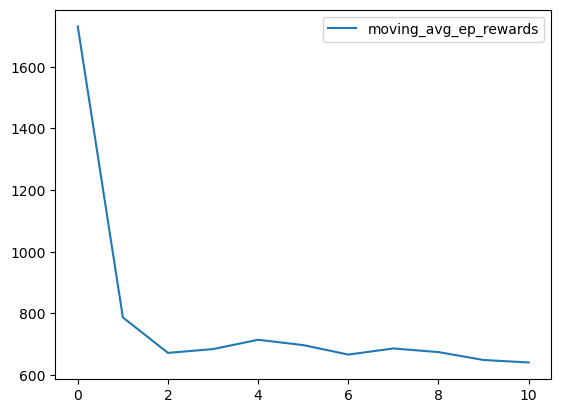

In [ ]:
use_cuda = torch.cuda.is_available()
print(f"Using CUDA: {use_cuda}")
print()

save_dir = Path("checkpoints") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
save_dir.mkdir(parents=True)

mario = Mario(state_dim=(4, 84, 84), action_dim=env.action_space.n, save_dir=save_dir)

logger = MetricLogger(save_dir)

episodes = 200
for e in range(episodes):

    state = env.reset()

    # Play the game!
    while True:

        # Run agent on the state
        action = mario.act(state)

        # Agent performs action
        next_state, reward, done, trunc, info = env.step(action)

        # Remember
        mario.cache(state, next_state, action, reward, done)

        # Learn
        q, loss = mario.learn()

        # Logging
        logger.log_step(reward, loss, q)

        # Update state
        state = next_state

        # Check if end of game
        if done or info["flag_get"]:
            break

    logger.log_episode()

    if (e % 20 == 0) or (e == episodes - 1):
        logger.record(episode=e, epsilon=mario.exploration_rate, step=mario.curr_step)

## Pendulum: writing environment and transforms with TorchRL

Creating an environment (a simulator or an interface to a physical
control system) is an integrative part of reinforcement learning and
control engineering.

TorchRL provides a set of tools to do this in multiple contexts. This
tutorial demonstrates how to use PyTorch and TorchRL code a pendulum
simulator from the ground up. It is freely inspired by the Pendulum-v1
implementation from [OpenAI-Gym/Farama-Gymnasium control
library](https://github.com/Farama-Foundation/Gymnasium).

![Simple
Pendulum](https://pytorch.org/tutorials/_static/img/pendulum.gif){.align-center}

Key learnings:

-   How to design an environment in TorchRL:
    -   Writing specs (input, observation and reward);
    -   Implementing behavior: seeding, reset and step.
-   Transforming your environment inputs and outputs, and writing your
    own transforms;
-   How to use `~tensordict.TensorDict`{.interpreted-text role="class"}
    to carry arbitrary data structures through the `codebase`.

    In the process, we will touch three crucial components of TorchRL:

-   [environments](https://pytorch.org/rl/reference/envs.html)
-   [transforms](https://pytorch.org/rl/reference/envs.html#transforms)
-   [models (policy and value
    function)](https://pytorch.org/rl/reference/modules.html)

To give a sense of what can be achieved with TorchRL\'s environments, we
will be designing a *stateless* environment. While stateful environments
keep track of the latest physical state encountered and rely on this to
simulate the state-to-state transition, stateless environments expect
the current state to be provided to them at each step, along with the
action undertaken. TorchRL supports both types of environments, but
stateless environments are more generic and hence cover a broader range
of features of the environment API in TorchRL.

Modeling stateless environments gives users full control over the input
and outputs of the simulator: one can reset an experiment at any stage
or actively modify the dynamics from the outside. However, it assumes
that we have some control over a task, which may not always be the case:
solving a problem where we cannot control the current state is more
challenging but has a much wider set of applications.

Another advantage of stateless environments is that they can enable
batched execution of transition simulations. If the backend and the
implementation allow it, an algebraic operation can be executed
seamlessly on scalars, vectors, or tensors. This tutorial gives such
examples.

This tutorial will be structured as follows:

-   We will first get acquainted with the environment properties: its
    shape (`batch_size`), its methods (mainly
    `~torchrl.envs.EnvBase.step`{.interpreted-text role="meth"},
    `~torchrl.envs.EnvBase.reset`{.interpreted-text role="meth"} and
    `~torchrl.envs.EnvBase.set_seed`{.interpreted-text role="meth"}) and
    finally its specs.
-   After having coded our simulator, we will demonstrate how it can be
    used during training with transforms.
-   We will explore new avenues that follow from the TorchRL\'s API,
    including: the possibility of transforming inputs, the vectorized
    execution of the simulation and the possibility of backpropagation
    through the simulation graph.
-   Finally, we will train a simple policy to solve the system we
    implemented.


In [ ]:
from collections import defaultdict
from typing import Optional

import numpy as np
import torch
import tqdm
from tensordict import TensorDict, TensorDictBase
from tensordict.nn import TensorDictModule
from torch import nn

from torchrl.data import BoundedTensorSpec, CompositeSpec, UnboundedContinuousTensorSpec
from torchrl.envs import (
    CatTensors,
    EnvBase,
    Transform,
    TransformedEnv,
    UnsqueezeTransform,
)
from torchrl.envs.transforms.transforms import _apply_to_composite
from torchrl.envs.utils import check_env_specs, step_mdp

DEFAULT_X = np.pi
DEFAULT_Y = 1.0

### Environment

There are four things you must take care of when designing a new
environment class:

-   `EnvBase._reset`{.interpreted-text role="meth"}, which codes for the
    resetting of the simulator at a (potentially random) initial state;
-   `EnvBase._step`{.interpreted-text role="meth"} which codes for the
    state transition dynamic;
-   `EnvBase._set_seed`{.interpreted-text role="meth"}\` which
    implements the seeding mechanism;
-   the environment specs.

Let us first describe the problem at hand: we would like to model a
simple pendulum over which we can control the torque applied on its
fixed point. Our goal is to place the pendulum in upward position
(angular position at 0 by convention) and having it standing still in
that position. To design our dynamic system, we need to define two
equations: the motion equation following an action (the torque applied)
and the reward equation that will constitute our objective function.

For the motion equation, we will update the angular velocity following:

$$\dot{\theta}_{t+1} = \dot{\theta}_t + (3 * g / (2 * L) * \sin(\theta_t) + 3 / (m * L^2) * u) * dt$$

where $\dot{\theta}$ is the angular velocity in rad/sec, $g$ is the
gravitational force, $L$ is the pendulum length, $m$ is its mass,
$\theta$ is its angular position and $u$ is the torque. The angular
position is then updated according to

$$\theta_{t+1} = \theta_{t} + \dot{\theta}_{t+1} dt$$

We define our reward as

$$r = -(\theta^2 + 0.1 * \dot{\theta}^2 + 0.001 * u^2)$$

which will be maximized when the angle is close to 0 (pendulum in upward
position), the angular velocity is close to 0 (no motion) and the torque
is 0 too.

#### Coding the effect of an action: `~torchrl.envs.EnvBase._step`

The step method is the first thing to consider, as it will encode the
simulation that is of interest to us. In TorchRL, the
`~torchrl.envs.EnvBase`{.interpreted-text role="class"} class has a
`EnvBase.step`{.interpreted-text role="meth"} method that receives a
`tensordict.TensorDict`{.interpreted-text role="class"} instance with an
`"action"` entry indicating what action is to be taken.

To facilitate the reading and writing from that `tensordict` and to make
sure that the keys are consistent with what\'s expected from the
library, the simulation part has been delegated to a private abstract
method `_step`{.interpreted-text role="meth"} which reads input data
from a `tensordict`, and writes a *new* `tensordict` with the output
data.

The `_step`{.interpreted-text role="func"} method should do the
following:

> 1.  Read the input keys (such as `"action"`) and execute the
>     simulation based on these;
> 2.  Retrieve observations, done state and reward;
> 3.  Write the set of observation values along with the reward and done
>     state at the corresponding entries in a new
>     `TensorDict`{.interpreted-text role="class"}.

Next, the `~torchrl.envs.EnvBase.step`{.interpreted-text role="meth"}
method will merge the output of
`~torchrl.envs.EnvBase.step`{.interpreted-text role="meth"} in the input
`tensordict` to enforce input/output consistency.

Typically, for stateful environments, this will look like this:

``` {.sourceCode .}
>>> policy(env.reset())
>>> print(tensordict)
TensorDict(
    fields={
        action: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        observation: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([]),
    device=cpu,
    is_shared=False)
>>> env.step(tensordict)
>>> print(tensordict)
TensorDict(
    fields={
        action: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                reward: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([]),
            device=cpu,
            is_shared=False),
        observation: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([]),
    device=cpu,
    is_shared=False)
```

Notice that the root `tensordict` has not changed, the only modification
is the appearance of a new `"next"` entry that contains the new
information.

In the Pendulum example, our `_step`{.interpreted-text role="meth"}
method will read the relevant entries from the input `tensordict` and
compute the position and velocity of the pendulum after the force
encoded by the `"action"` key has been applied onto it. We compute the
new angular position of the pendulum `"new_th"` as the result of the
previous position `"th"` plus the new velocity `"new_thdot"` over a time
interval `dt`.

Since our goal is to turn the pendulum up and maintain it still in that
position, our `cost` (negative reward) function is lower for positions
close to the target and low speeds. Indeed, we want to discourage
positions that are far from being \"upward\" and/or speeds that are far
from 0.

In our example, `EnvBase._step`{.interpreted-text role="meth"} is
encoded as a static method since our environment is stateless. In
stateful settings, the `self` argument is needed as the state needs to
be read from the environment.


In [ ]:
def _step(tensordict):
    th, thdot = tensordict["th"], tensordict["thdot"]  # th := theta

    g_force = tensordict["params", "g"]
    mass = tensordict["params", "m"]
    length = tensordict["params", "l"]
    dt = tensordict["params", "dt"]
    u = tensordict["action"].squeeze(-1)
    u = u.clamp(-tensordict["params", "max_torque"], tensordict["params", "max_torque"])
    costs = angle_normalize(th) ** 2 + 0.1 * thdot**2 + 0.001 * (u**2)

    new_thdot = (
        thdot
        + (3 * g_force / (2 * length) * th.sin() + 3.0 / (mass * length**2) * u) * dt
    )
    new_thdot = new_thdot.clamp(
        -tensordict["params", "max_speed"], tensordict["params", "max_speed"]
    )
    new_th = th + new_thdot * dt
    reward = -costs.view(*tensordict.shape, 1)
    done = torch.zeros_like(reward, dtype=torch.bool)
    out = TensorDict(
        {
            "th": new_th,
            "thdot": new_thdot,
            "params": tensordict["params"],
            "reward": reward,
            "done": done,
        },
        tensordict.shape,
    )
    return out


def angle_normalize(x):
    return ((x + torch.pi) % (2 * torch.pi)) - torch.pi

#### Resetting the simulator: `~torchrl.envs.EnvBase._reset`

The second method we need to care about is the
`~torchrl.envs.EnvBase._reset`{.interpreted-text role="meth"} method.
Like `~torchrl.envs.EnvBase._step`{.interpreted-text role="meth"}, it
should write the observation entries and possibly a done state in the
`tensordict` it outputs (if the done state is omitted, it will be filled
as `False` by the parent method
`~torchrl.envs.EnvBase.reset`{.interpreted-text role="meth"}). In some
contexts, it is required that the `_reset` method receives a command
from the function that called it (for example, in multi-agent settings
we may want to indicate which agents need to be reset). This is why the
`~torchrl.envs.EnvBase._reset`{.interpreted-text role="meth"} method
also expects a `tensordict` as input, albeit it may perfectly be empty
or `None`.

The parent `EnvBase.reset`{.interpreted-text role="meth"} does some
simple checks like the `EnvBase.step`{.interpreted-text role="meth"}
does, such as making sure that a `"done"` state is returned in the
output `tensordict` and that the shapes match what is expected from the
specs.

For us, the only important thing to consider is whether
`EnvBase._reset`{.interpreted-text role="meth"} contains all the
expected observations. Once more, since we are working with a stateless
environment, we pass the configuration of the pendulum in a nested
`tensordict` named `"params"`.

In this example, we do not pass a done state as this is not mandatory
for `_reset`{.interpreted-text role="meth"} and our environment is
non-terminating, so we always expect it to be `False`.


In [ ]:
def _reset(self, tensordict):
    if tensordict is None or tensordict.is_empty():
        # if no ``tensordict`` is passed, we generate a single set of hyperparameters
        # Otherwise, we assume that the input ``tensordict`` contains all the relevant
        # parameters to get started.
        tensordict = self.gen_params(batch_size=self.batch_size)

    high_th = torch.tensor(DEFAULT_X, device=self.device)
    high_thdot = torch.tensor(DEFAULT_Y, device=self.device)
    low_th = -high_th
    low_thdot = -high_thdot

    # for non batch-locked environments, the input ``tensordict`` shape dictates the number
    # of simulators run simultaneously. In other contexts, the initial
    # random state's shape will depend upon the environment batch-size instead.
    th = (
        torch.rand(tensordict.shape, generator=self.rng, device=self.device)
        * (high_th - low_th)
        + low_th
    )
    thdot = (
        torch.rand(tensordict.shape, generator=self.rng, device=self.device)
        * (high_thdot - low_thdot)
        + low_thdot
    )
    out = TensorDict(
        {
            "th": th,
            "thdot": thdot,
            "params": tensordict["params"],
        },
        batch_size=tensordict.shape,
    )
    return out

#### Environment metadata: `env.*_spec`

The specs define the input and output domain of the environment. It is
important that the specs accurately define the tensors that will be
received at runtime, as they are often used to carry information about
environments in multiprocessing and distributed settings. They can also
be used to instantiate lazily defined neural networks and test scripts
without actually querying the environment (which can be costly with
real-world physical systems for instance).

There are four specs that we must code in our environment:

-   `EnvBase.observation_spec`{.interpreted-text role="obj"}: This will
    be a `~torchrl.data.CompositeSpec`{.interpreted-text role="class"}
    instance where each key is an observation (a
    `CompositeSpec`{.interpreted-text role="class"} can be viewed as a
    dictionary of specs).
-   `EnvBase.action_spec`{.interpreted-text role="obj"}: It can be any
    type of spec, but it is required that it corresponds to the
    `"action"` entry in the input `tensordict`;
-   `EnvBase.reward_spec`{.interpreted-text role="obj"}: provides
    information about the reward space;
-   `EnvBase.done_spec`{.interpreted-text role="obj"}: provides
    information about the space of the done flag.

TorchRL specs are organized in two general containers: `input_spec`
which contains the specs of the information that the step function reads
(divided between `action_spec` containing the action and `state_spec`
containing all the rest), and `output_spec` which encodes the specs that
the step outputs (`observation_spec`, `reward_spec` and `done_spec`). In
general, you should not interact directly with `output_spec` and
`input_spec` but only with their content: `observation_spec`,
`reward_spec`, `done_spec`, `action_spec` and `state_spec`. The reason
if that the specs are organized in a non-trivial way within
`output_spec` and `input_spec` and neither of these should be directly
modified.

In other words, the `observation_spec` and related properties are
convenient shortcuts to the content of the output and input spec
containers.

TorchRL offers multiple `~torchrl.data.TensorSpec`{.interpreted-text
role="class"}
[subclasses](https://pytorch.org/rl/reference/data.html#tensorspec) to
encode the environment\'s input and output characteristics.

#### Specs shape

The environment specs leading dimensions must match the environment
batch-size. This is done to enforce that every component of an
environment (including its transforms) have an accurate representation
of the expected input and output shapes. This is something that should
be accurately coded in stateful settings.

For non batch-locked environments, such as the one in our example (see
below), this is irrelevant as the environment batch size will most
likely be empty.


In [ ]:
def _make_spec(self, td_params):
    # Under the hood, this will populate self.output_spec["observation"]
    self.observation_spec = CompositeSpec(
        th=BoundedTensorSpec(
            low=-torch.pi,
            high=torch.pi,
            shape=(),
            dtype=torch.float32,
        ),
        thdot=BoundedTensorSpec(
            low=-td_params["params", "max_speed"],
            high=td_params["params", "max_speed"],
            shape=(),
            dtype=torch.float32,
        ),
        # we need to add the ``params`` to the observation specs, as we want
        # to pass it at each step during a rollout
        params=make_composite_from_td(td_params["params"]),
        shape=(),
    )
    # since the environment is stateless, we expect the previous output as input.
    # For this, ``EnvBase`` expects some state_spec to be available
    self.state_spec = self.observation_spec.clone()
    # action-spec will be automatically wrapped in input_spec when
    # `self.action_spec = spec` will be called supported
    self.action_spec = BoundedTensorSpec(
        low=-td_params["params", "max_torque"],
        high=td_params["params", "max_torque"],
        shape=(1,),
        dtype=torch.float32,
    )
    self.reward_spec = UnboundedContinuousTensorSpec(shape=(*td_params.shape, 1))


def make_composite_from_td(td):
    # custom function to convert a ``tensordict`` in a similar spec structure
    # of unbounded values.
    composite = CompositeSpec(
        {
            key: make_composite_from_td(tensor)
            if isinstance(tensor, TensorDictBase)
            else UnboundedContinuousTensorSpec(
                dtype=tensor.dtype, device=tensor.device, shape=tensor.shape
            )
            for key, tensor in td.items()
        },
        shape=td.shape,
    )
    return composite

#### Reproducible experiments: seeding

Seeding an environment is a common operation when initializing an
experiment. The only goal of `EnvBase._set_seed`{.interpreted-text
role="func"} is to set the seed of the contained simulator. If possible,
this operation should not call `reset()` or interact with the
environment execution. The parent `EnvBase.set_seed`{.interpreted-text
role="func"} method incorporates a mechanism that allows seeding
multiple environments with a different pseudo-random and reproducible
seed.


In [ ]:
def _set_seed(self, seed: Optional[int]):
    rng = torch.manual_seed(seed)
    self.rng = rng

#### Wrapping things together: the `~torchrl.envs.EnvBase`{.interpreted-text role="class"} class

We can finally put together the pieces and design our environment class.
The specs initialization needs to be performed during the environment
construction, so we must take care of calling the
`_make_spec`{.interpreted-text role="func"} method within
`PendulumEnv.__init__`{.interpreted-text role="func"}.

We add a static method `PendulumEnv.gen_params`{.interpreted-text
role="meth"} which deterministically generates a set of hyperparameters
to be used during execution:


In [ ]:
def gen_params(g=10.0, batch_size=None) -> TensorDictBase:
    """Returns a ``tensordict`` containing the physical parameters such as gravitational force and torque or speed limits."""
    if batch_size is None:
        batch_size = []
    td = TensorDict(
        {
            "params": TensorDict(
                {
                    "max_speed": 8,
                    "max_torque": 2.0,
                    "dt": 0.05,
                    "g": g,
                    "m": 1.0,
                    "l": 1.0,
                },
                [],
            )
        },
        [],
    )
    if batch_size:
        td = td.expand(batch_size).contiguous()
    return td

We define the environment as non-`batch_locked` by turning the
`homonymous` attribute to `False`. This means that we will **not**
enforce the input `tensordict` to have a `batch-size` that matches the
one of the environment.

The following code will just put together the pieces we have coded
above.


In [ ]:
class PendulumEnv(EnvBase):
    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 30,
    }
    batch_locked = False

    def __init__(self, td_params=None, seed=None, device="cpu"):
        if td_params is None:
            td_params = self.gen_params()

        super().__init__(device=device, batch_size=[])
        self._make_spec(td_params)
        if seed is None:
            seed = torch.empty((), dtype=torch.int64).random_().item()
        self.set_seed(seed)

    # Helpers: _make_step and gen_params
    gen_params = staticmethod(gen_params)
    _make_spec = _make_spec

    # Mandatory methods: _step, _reset and _set_seed
    _reset = _reset
    _step = staticmethod(_step)
    _set_seed = _set_seed

#### Testing our environment

TorchRL provides a simple function
`~torchrl.envs.utils.check_env_specs`{.interpreted-text role="func"} to
check that a (transformed) environment has an input/output structure
that matches the one dictated by its specs. Let us try it out:


In [ ]:
env = PendulumEnv()
check_env_specs(env)

2024-07-14 21:07:44,523 [torchrl][INFO] check_env_specs succeeded!


We can have a look at our specs to have a visual representation of the
environment signature:


In [ ]:
print("observation_spec:", env.observation_spec)
print("state_spec:", env.state_spec)
print("reward_spec:", env.reward_spec)

observation_spec: CompositeSpec(
    th: BoundedTensorSpec(
        shape=torch.Size([]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, contiguous=True),
            high=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, contiguous=True)),
        device=cpu,
        dtype=torch.float32,
        domain=continuous),
    thdot: BoundedTensorSpec(
        shape=torch.Size([]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, contiguous=True),
            high=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, contiguous=True)),
        device=cpu,
        dtype=torch.float32,
        domain=continuous),
    params: CompositeSpec(
        max_speed: UnboundedContinuousTensorSpec(
            shape=torch.Size([]),
            space=None,
            device=cpu,
            dtype=torch.int64,
            domain=discrete),
        max_torque: UnboundedC

We can execute a couple of commands too to check that the output
structure matches what is expected.


In [ ]:
td = env.reset()
print("reset tensordict", td)

reset tensordict TensorDict(
    fields={
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        params: TensorDict(
            fields={
                dt: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                g: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                l: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                m: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                max_speed: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, is_shared=False),
                max_torque: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([]),
            device=None,
            is_shared=False),
        terminated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        th: Te

We can run the `env.rand_step`{.interpreted-text role="func"} to
generate an action randomly from the `action_spec` domain. A
`tensordict` containing the hyperparameters and the current state
**must** be passed since our environment is stateless. In stateful
contexts, `env.rand_step()` works perfectly too.


In [ ]:
td = env.rand_step(td)
print("random step tensordict", td)

random step tensordict TensorDict(
    fields={
        action: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
                params: TensorDict(
                    fields={
                        dt: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                        g: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                        l: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                        m: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                        max_speed: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, is_shared=False),
         

### Transforming an environment

Writing environment transforms for stateless simulators is slightly more
complicated than for stateful ones: transforming an output entry that
needs to be read at the following iteration requires to apply the
inverse transform before calling `meth.step`{.interpreted-text
role="func"} at the next step. This is an ideal scenario to showcase all
the features of TorchRL\'s transforms!

For instance, in the following transformed environment we `unsqueeze`
the entries `["th", "thdot"]` to be able to stack them along the last
dimension. We also pass them as `in_keys_inv` to squeeze them back to
their original shape once they are passed as input in the next
iteration.


In [ ]:
env = TransformedEnv(
    env,
    # ``Unsqueeze`` the observations that we will concatenate
    UnsqueezeTransform(
        unsqueeze_dim=-1,
        in_keys=["th", "thdot"],
        in_keys_inv=["th", "thdot"],
    ),
)

#### Writing custom transforms

TorchRL\'s transforms may not cover all the operations one wants to
execute after an environment has been executed. Writing a transform does
not require much effort. As for the environment design, there are two
steps in writing a transform:

-   Getting the dynamics right (forward and inverse);
-   Adapting the environment specs.

A transform can be used in two settings: on its own, it can be used as a
`~torch.nn.Module`{.interpreted-text role="class"}. It can also be used
appended to a
`~torchrl.envs.transforms.TransformedEnv`{.interpreted-text
role="class"}. The structure of the class allows to customize the
behavior in the different contexts.

A `~torchrl.envs.transforms.Transform`{.interpreted-text role="class"}
skeleton can be summarized as follows:

``` {.sourceCode .}
class Transform(nn.Module):
    def forward(self, tensordict):
        ...
    def _apply_transform(self, tensordict):
        ...
    def _step(self, tensordict):
        ...
    def _call(self, tensordict):
        ...
    def inv(self, tensordict):
        ...
    def _inv_apply_transform(self, tensordict):
        ...
```

There are three entry points (`forward`{.interpreted-text role="func"},
`_step`{.interpreted-text role="func"} and `inv`{.interpreted-text
role="func"}) which all receive
`tensordict.TensorDict`{.interpreted-text role="class"} instances. The
first two will eventually go through the keys indicated by
`~tochrl.envs.transforms.Transform.in_keys`{.interpreted-text
role="obj"} and call
`~torchrl.envs.transforms.Transform._apply_transform`{.interpreted-text
role="meth"} to each of these. The results will be written in the
entries pointed by `Transform.out_keys`{.interpreted-text role="obj"} if
provided (if not the `in_keys` will be updated with the transformed
values). If inverse transforms need to be executed, a similar data flow
will be executed but with the `Transform.inv`{.interpreted-text
role="func"} and `Transform._inv_apply_transform`{.interpreted-text
role="func"} methods and across the `in_keys_inv` and `out_keys_inv`
list of keys. The following figure summarized this flow for environments
and replay buffers.

> Transform API

In some cases, a transform will not work on a subset of keys in a
unitary manner, but will execute some operation on the parent
environment or work with the entire input `tensordict`. In those cases,
the `_call`{.interpreted-text role="func"} and
`forward`{.interpreted-text role="func"} methods should be re-written,
and the `_apply_transform`{.interpreted-text role="func"} method can be
skipped.

Let us code new transforms that will compute the `sine` and `cosine`
values of the position angle, as these values are more useful to us to
learn a policy than the raw angle value:


In [ ]:
class SinTransform(Transform):
    def _apply_transform(self, obs: torch.Tensor) -> None:
        return obs.sin()

    # The transform must also modify the data at reset time
    def _reset(
        self, tensordict: TensorDictBase, tensordict_reset: TensorDictBase
    ) -> TensorDictBase:
        return self._call(tensordict_reset)

    # _apply_to_composite will execute the observation spec transform across all
    # in_keys/out_keys pairs and write the result in the observation_spec which
    # is of type ``Composite``
    @_apply_to_composite
    def transform_observation_spec(self, observation_spec):
        return BoundedTensorSpec(
            low=-1,
            high=1,
            shape=observation_spec.shape,
            dtype=observation_spec.dtype,
            device=observation_spec.device,
        )


class CosTransform(Transform):
    def _apply_transform(self, obs: torch.Tensor) -> None:
        return obs.cos()

    # The transform must also modify the data at reset time
    def _reset(
        self, tensordict: TensorDictBase, tensordict_reset: TensorDictBase
    ) -> TensorDictBase:
        return self._call(tensordict_reset)

    # _apply_to_composite will execute the observation spec transform across all
    # in_keys/out_keys pairs and write the result in the observation_spec which
    # is of type ``Composite``
    @_apply_to_composite
    def transform_observation_spec(self, observation_spec):
        return BoundedTensorSpec(
            low=-1,
            high=1,
            shape=observation_spec.shape,
            dtype=observation_spec.dtype,
            device=observation_spec.device,
        )


t_sin = SinTransform(in_keys=["th"], out_keys=["sin"])
t_cos = CosTransform(in_keys=["th"], out_keys=["cos"])
env.append_transform(t_sin)
env.append_transform(t_cos)

Once more, let us check that our environment specs match what is
received:


In [ ]:
check_env_specs(env)

#### Executing a rollout

Executing a rollout is a succession of simple steps:

-   reset the environment
-   while some condition is not met:
    -   compute an action given a policy
    -   execute a step given this action
    -   collect the data
    -   make a `MDP` step
-   gather the data and return

These operations have been conveniently wrapped in the
`~torchrl.envs.EnvBase.rollout`{.interpreted-text role="meth"} method,
from which we provide a simplified version here below.


In [ ]:
def simple_rollout(steps=100):
    # preallocate:
    data = TensorDict({}, [steps])
    # reset
    _data = env.reset()
    for i in range(steps):
        _data["action"] = env.action_spec.rand()
        _data = env.step(_data)
        data[i] = _data
        _data = step_mdp(_data, keep_other=True)
    return data


print("data from rollout:", simple_rollout(100))

#### Batching computations

The last unexplored end of our tutorial is the ability that we have to
batch computations in TorchRL. Because our environment does not make any
assumptions regarding the input data shape, we can seamlessly execute it
over batches of data. Even better: for non-batch-locked environments
such as our Pendulum, we can change the batch size on the fly without
recreating the environment. To do this, we just generate parameters with
the desired shape.


In [ ]:
batch_size = 10  # number of environments to be executed in batch
td = env.reset(env.gen_params(batch_size=[batch_size]))
print("reset (batch size of 10)", td)
td = env.rand_step(td)
print("rand step (batch size of 10)", td)

Executing a rollout with a batch of data requires us to reset the
environment out of the rollout function, since we need to define the
batch\_size dynamically and this is not supported by
`~torchrl.envs.EnvBase.rollout`{.interpreted-text role="meth"}:


In [ ]:
rollout = env.rollout(
    3,
    auto_reset=False,  # we're executing the reset out of the ``rollout`` call
    tensordict=env.reset(env.gen_params(batch_size=[batch_size])),
)
print("rollout of len 3 (batch size of 10):", rollout)

### Training a simple policy

In this example, we will train a simple policy using the reward as a
differentiable objective, such as a negative loss. We will take
advantage of the fact that our dynamic system is fully differentiable to
backpropagate through the trajectory return and adjust the weights of
our policy to maximize this value directly. Of course, in many settings
many of the assumptions we make do not hold, such as differentiable
system and full access to the underlying mechanics.

Still, this is a very simple example that showcases how a training loop
can be coded with a custom environment in TorchRL.

Let us first write the policy network:


In [ ]:
torch.manual_seed(0)
env.set_seed(0)

net = nn.Sequential(
    nn.LazyLinear(64),
    nn.Tanh(),
    nn.LazyLinear(64),
    nn.Tanh(),
    nn.LazyLinear(64),
    nn.Tanh(),
    nn.LazyLinear(1),
)
policy = TensorDictModule(
    net,
    in_keys=["observation"],
    out_keys=["action"],
)

and our optimizer:


In [ ]:
optim = torch.optim.Adam(policy.parameters(), lr=2e-3)

#### Training loop

We will successively:

-   generate a trajectory
-   sum the rewards
-   backpropagate through the graph defined by these operations
-   clip the gradient norm and make an optimization step
-   repeat

At the end of the training loop, we should have a final reward close to
0 which demonstrates that the pendulum is upward and still as desired.


In [ ]:
batch_size = 32
pbar = tqdm.tqdm(range(20_000 // batch_size))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, 20_000)
logs = defaultdict(list)

for _ in pbar:
    init_td = env.reset(env.gen_params(batch_size=[batch_size]))
    rollout = env.rollout(100, policy, tensordict=init_td, auto_reset=False)
    traj_return = rollout["next", "reward"].mean()
    (-traj_return).backward()
    gn = torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
    optim.step()
    optim.zero_grad()
    pbar.set_description(
        f"reward: {traj_return: 4.4f}, "
        f"last reward: {rollout[..., -1]['next', 'reward'].mean(): 4.4f}, gradient norm: {gn: 4.4}"
    )
    logs["return"].append(traj_return.item())
    logs["last_reward"].append(rollout[..., -1]["next", "reward"].mean().item())
    scheduler.step()


def plot():
    import matplotlib
    from matplotlib import pyplot as plt

    is_ipython = "inline" in matplotlib.get_backend()
    if is_ipython:
        from IPython import display

    with plt.ion():
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(logs["return"])
        plt.title("returns")
        plt.xlabel("iteration")
        plt.subplot(1, 2, 2)
        plt.plot(logs["last_reward"])
        plt.title("last reward")
        plt.xlabel("iteration")
        if is_ipython:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        plt.show()


plot()

### Conclusion

In this tutorial, we have learned how to code a stateless environment
from scratch. We touched the subjects of:

-   The four essential components that need to be taken care of when
    coding an environment (`step`, `reset`, seeding and building specs).
    We saw how these methods and classes interact with the
    `~tensordict.TensorDict`{.interpreted-text role="class"} class;
-   How to test that an environment is properly coded using
    `~torchrl.envs.utils.check_env_specs`{.interpreted-text
    role="func"};
-   How to append transforms in the context of stateless environments
    and how to write custom transformations;
-   How to train a policy on a fully differentiable simulator.


### Pendulum practice

In [ ]:
from collections import defaultdict
from typing import Optional

import numpy as np
import torch
import tqdm
from tensordict import TensorDict, TensorDictBase
from tensordict.nn import TensorDictModule
from torch import nn

from torchrl.data import BoundedTensorSpec, CompositeSpec, UnboundedContinuousTensorSpec
from torchrl.envs import (
    CatTensors,
    EnvBase,
    Transform,
    TransformedEnv,
    UnsqueezeTransform,
)
from torchrl.envs.transforms.transforms import _apply_to_composite
from torchrl.envs.utils import check_env_specs, step_mdp

DEFAULT_X = np.pi
DEFAULT_Y = 1.0



In [ ]:
def _step(tensordict):
    th, thdot = tensordict["th"], tensordict["thdot"]  # th := theta

    g_force = tensordict["params", "g"]
    mass = tensordict["params", "m"]
    length = tensordict["params", "l"]
    dt = tensordict["params", "dt"]
    u = tensordict["action"].squeeze(-1)
    u = u.clamp(-tensordict["params", "max_torque"], tensordict["params", "max_torque"])
    costs = angle_normalize(th) ** 2 + 0.1 * thdot**2 + 0.001 * (u**2)

    new_thdot = (
        thdot
        + (3 * g_force / (2 * length) * th.sin() + 3.0 / (mass * length**2) * u) * dt
    )
    new_thdot = new_thdot.clamp(
        -tensordict["params", "max_speed"], tensordict["params", "max_speed"]
    )
    new_th = th + new_thdot * dt
    reward = -costs.view(*tensordict.shape, 1)
    done = torch.zeros_like(reward, dtype=torch.bool)
    out = TensorDict(
        {
            "th": new_th,
            "thdot": new_thdot,
            "params": tensordict["params"],
            "reward": reward,
            "done": done,
        },
        tensordict.shape,
    )
    return out


def angle_normalize(x):
    return ((x + torch.pi) % (2 * torch.pi)) - torch.pi

def _reset(self, tensordict):
    if tensordict is None or tensordict.is_empty():
        # if no ``tensordict`` is passed, we generate a single set of hyperparameters
        # Otherwise, we assume that the input ``tensordict`` contains all the relevant
        # parameters to get started.
        tensordict = self.gen_params(batch_size=self.batch_size)

    high_th = torch.tensor(DEFAULT_X, device=self.device)
    high_thdot = torch.tensor(DEFAULT_Y, device=self.device)
    low_th = -high_th
    low_thdot = -high_thdot

    # for non batch-locked environments, the input ``tensordict`` shape dictates the number
    # of simulators run simultaneously. In other contexts, the initial
    # random state's shape will depend upon the environment batch-size instead.
    th = (
        torch.rand(tensordict.shape, generator=self.rng, device=self.device)
        * (high_th - low_th)
        + low_th
    )
    thdot = (
        torch.rand(tensordict.shape, generator=self.rng, device=self.device)
        * (high_thdot - low_thdot)
        + low_thdot
    )
    out = TensorDict(
        {
            "th": th,
            "thdot": thdot,
            "params": tensordict["params"],
        },
        batch_size=tensordict.shape,
    )
    return out

def _make_spec(self, td_params):
    self.observation_spec = CompositeSpec(
        th=BoundedTensorSpec(
            low=-torch.pi,
            high=torch.pi,
            shape=(),
            dtype=torch.float32,
        ),
        thdot=BoundedTensorSpec(
            low=-td_params["params", "max_speed"],
            high=td_params["params", "max_speed"],
            shape=(),
            dtype=torch.float32,
        ),
        params=make_composite_from_td(td_params["params"]),
        shape=(),
    )

    self.state_spec = self.observation_spec.clone()
    self.action_spec = BoundedTensorSpec(
        low=-td_params["params", "max_torque"],
        high=td_params["params", "max_torque"],
        shape=(1,),
        dtype=torch.float32,
    )
    self.reward_spc = UnboundedContinuousTensorSpec(shape=(*td_params.shape, 1))

def make_composite_from_td(td):
    # custom function to convert a ``tensordict`` in a similar spec structure
    # of unbounded values.
    composite = CompositeSpec(
        {
            key: make_composite_from_td(tensor)
            if isinstance(tensor, TensorDictBase)
            else UnboundedContinuousTensorSpec(
                dtype=tensor.dtype, device=tensor.device, shape=tensor.shape
            )
            for key, tensor in td.items()
        },
        shape=td.shape,
    )
    return composite

def _set_seed(self, seed: Optional[int]):
    rng = torch.manual_seed(seed)
    self.rng = rng

def gen_params(g=10.0, batch_size=None) -> TensorDictBase:
    """Returns a ``tensordict`` containing the physical parameters such as gravitational force and torque or speed limits."""
    if batch_size is None:
        batch_size = []
    td = TensorDict(
        {
            "params": TensorDict(
                {
                    "max_speed": 8,
                    "max_torque": 2.0,
                    "dt": 0.05,
                    "g": g,
                    "m": 1.0,
                    "l": 1.0,
                },
                [],
            )
        },
        [],
    )
    if batch_size:
        td = td.expand(batch_size).contiguous()
    return td

class PendulumEnv(EnvBase):
    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 30,
    }
    batch_locked = False

    def __init__(self, td_params=None, seed=None, device="cpu"):
        if td_params is None:
            td_params = self.gen_params()

        super().__init__(device=device, batch_size=[])
        self._make_spec(td_params)
        if seed is None:
            seed = torch.empty((), dtype=torch.int64).random_().item()
        self.set_seed(seed)

    # Helpers: _make_step and gen_params
    gen_params = staticmethod(gen_params)
    _make_spec = _make_spec

    # Mandatory methods: _step, _reset and _set_seed
    _reset = _reset
    _step = staticmethod(_step)
    _set_seed = _set_seed

In [ ]:
env = PendulumEnv()
check_env_specs(env)

2024-07-21 22:05:16,718 [torchrl][INFO] check_env_specs succeeded!


In [ ]:
print("observation_spec:", env.observation_spec)
print("state_spec:", env.state_spec)
print("reward_spec:", env.reward_spec)

observation_spec: CompositeSpec(
    th: BoundedTensorSpec(
        shape=torch.Size([]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, contiguous=True),
            high=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, contiguous=True)),
        device=cpu,
        dtype=torch.float32,
        domain=continuous),
    thdot: BoundedTensorSpec(
        shape=torch.Size([]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, contiguous=True),
            high=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, contiguous=True)),
        device=cpu,
        dtype=torch.float32,
        domain=continuous),
    params: CompositeSpec(
        max_speed: UnboundedContinuousTensorSpec(
            shape=torch.Size([]),
            space=None,
            device=cpu,
            dtype=torch.int64,
            domain=discrete),
        max_torque: UnboundedC

In [ ]:
td = env.reset()
print("reset tensordict", td)

reset tensordict TensorDict(
    fields={
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        params: TensorDict(
            fields={
                dt: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                g: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                l: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                m: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                max_speed: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, is_shared=False),
                max_torque: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([]),
            device=None,
            is_shared=False),
        terminated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        th: Te

In [ ]:
td = env.rand_step(td)
print("random step tensordict", td)

random step tensordict TensorDict(
    fields={
        action: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
                params: TensorDict(
                    fields={
                        dt: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                        g: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                        l: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                        m: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                        max_speed: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, is_shared=False),
         

In [ ]:
env = TransformedEnv(
    env,
    # ``Unsqueeze`` the observations that we will concatenate
    UnsqueezeTransform(
        unsqueeze_dim=-1,
        in_keys=["th", "thdot"],
        in_keys_inv=["th", "thdot"],
    ),
)

class Transform(nn.Module):
    def forward(self, tensordict):
        ...
    def _apply_transform(self, tensordict):
        ...
    def _step(self, tensordict):
        ...
    def _call(self, tensordict):
        ...
    def inv(self, tensordict):
        ...
    def _inv_apply_transform(self, tensordict):
        ...

class SinTransform(Transform):
    def _apply_transform(self, obs: torch.Tensor) -> None:
        return obs.sin()

    # The transform must also modify the data at reset time
    def _reset(
        self, tensordict: TensorDictBase, tensordict_reset: TensorDictBase
    ) -> TensorDictBase:
        return self._call(tensordict_reset)

    # _apply_to_composite will execute the observation spec transform across all
    # in_keys/out_keys pairs and write the result in the observation_spec which
    # is of type ``Composite``
    @_apply_to_composite
    def transform_observation_spec(self, observation_spec):
        return BoundedTensorSpec(
            low=-1,
            high=1,
            shape=observation_spec.shape,
            dtype=observation_spec.dtype,
            device=observation_spec.device,
        )


class CosTransform(Transform):
    def _apply_transform(self, obs: torch.Tensor) -> None:
        return obs.cos()

    # The transform must also modify the data at reset time
    def _reset(
        self, tensordict: TensorDictBase, tensordict_reset: TensorDictBase
    ) -> TensorDictBase:
        return self._call(tensordict_reset)

    # _apply_to_composite will execute the observation spec transform across all
    # in_keys/out_keys pairs and write the result in the observation_spec which
    # is of type ``Composite``
    @_apply_to_composite
    def transform_observation_spec(self, observation_spec):
        return BoundedTensorSpec(
            low=-1,
            high=1,
            shape=observation_spec.shape,
            dtype=observation_spec.dtype,
            device=observation_spec.device,
        )


t_sin = SinTransform(in_keys=["th"], out_keys=["sin"])
t_cos = CosTransform(in_keys=["th"], out_keys=["cos"])
env.append_transform(t_sin)
env.append_transform(t_cos)

cat_transform = CatTensors(
    in_keys=["sin", "cos", "thdot"], dim=-1, out_key="observation", del_keys=False
)
env.append_transform(cat_transform)

TypeError: SinTransform.__init__() got an unexpected keyword argument 'in_keys'

In [ ]:
def simple_rollout(steps=100):
    # preallocate:
    data = TensorDict({}, [steps])
    # reset
    _data = env.reset()
    for i in range(steps):
        _data["action"] = env.action_spec.rand()
        _data = env.step(_data)
        data[i] = _data
        _data = step_mdp(_data, keep_other=True)
    return data


print("data from rollout:", simple_rollout(100))

data from rollout: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([100, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        cos: Tensor(shape=torch.Size([100, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([100, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                cos: Tensor(shape=torch.Size([100, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                done: Tensor(shape=torch.Size([100, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                params: TensorDict(
                    fields={
                        dt: Tensor(shape=torch.Size([100]), device=cpu, dtype=torch.float32, is_shared=False),
                        g: Tensor(shape=torch.Size([100]), device=cpu, dtype=torch.float32, is_shared=False),
                        l: Tensor(shape=torch.Size([100]), device=cpu, dtype=torch.float32, is_shared=False),
   

In [ ]:
batch_size = 10  # number of environments to be executed in batch
td = env.reset(env.gen_params(batch_size=[batch_size]))
print("reset (batch size of 10)", td)
td = env.rand_step(td)
print("rand step (batch size of 10)", td)

reset (batch size of 10) TensorDict(
    fields={
        cos: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        params: TensorDict(
            fields={
                dt: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.float32, is_shared=False),
                g: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.float32, is_shared=False),
                l: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.float32, is_shared=False),
                m: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.float32, is_shared=False),
                max_speed: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.int64, is_shared=False),
                max_torque: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([10]),
            device=None,
            is_sha

In [ ]:
rollout = env.rollout(
    3,
    auto_reset=False,  # we're executing the reset out of the ``rollout`` call
    tensordict=env.reset(env.gen_params(batch_size=[batch_size])),
)
print("rollout of len 3 (batch size of 10):", rollout)

rollout of len 3 (batch size of 10): TensorDict(
    fields={
        action: Tensor(shape=torch.Size([10, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        cos: Tensor(shape=torch.Size([10, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([10, 3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                cos: Tensor(shape=torch.Size([10, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                done: Tensor(shape=torch.Size([10, 3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                params: TensorDict(
                    fields={
                        dt: Tensor(shape=torch.Size([10, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                        g: Tensor(shape=torch.Size([10, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                        l: Tensor(shape=torch.Size([10, 3]), device=cpu, dtype=to

In [ ]:
torch.manual_seed(0)
env.set_seed(0)

net = nn.Sequential(
    nn.LazyLinear(64),
    nn.Tanh(),
    nn.LazyLinear(64),
    nn.Tanh(),
    nn.LazyLinear(64),
    nn.Tanh(),
    nn.LazyLinear(1),
)
policy = TensorDictModule(
    net,
    in_keys=["observation"],
    out_keys=["action"],
)

optim = torch.optim.Adam(policy.parameters(), lr=2e-3)

batch_size = 32
pbar = tqdm.tqdm(range(20_000 // batch_size))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, 20_000)
logs = defaultdict(list)

for _ in pbar:
    init_td = env.reset(env.gen_params(batch_size=[batch_size]))
    rollout = env.rollout(100, policy, tensordict=init_td, auto_reset=False)
    traj_return = rollout["next", "reward"].mean()
    (-traj_return).backward()
    gn = torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
    optim.step()
    optim.zero_grad()
    pbar.set_description(
        f"reward: {traj_return: 4.4f}, "
        f"last reward: {rollout[..., -1]['next', 'reward'].mean(): 4.4f}, gradient norm: {gn: 4.4}"
    )
    logs["return"].append(traj_return.item())
    logs["last_reward"].append(rollout[..., -1]["next", "reward"].mean().item())
    scheduler.step()


def plot():
    import matplotlib
    from matplotlib import pyplot as plt

    is_ipython = "inline" in matplotlib.get_backend()
    if is_ipython:
        from IPython import display

    with plt.ion():
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(logs["return"])
        plt.title("returns")
        plt.xlabel("iteration")
        plt.subplot(1, 2, 2)
        plt.plot(logs["last_reward"])
        plt.title("last reward")
        plt.xlabel("iteration")
        if is_ipython:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        plt.show()


plot()

  0%|          | 0/625 [00:00<?, ?it/s]


KeyError: "Some tensors that are necessary for the module call may not have not been found in the input tensordict: the following inputs are None: {'observation'}."